# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 25 января 23:59

**Продуктивной и интересной вам работы!**

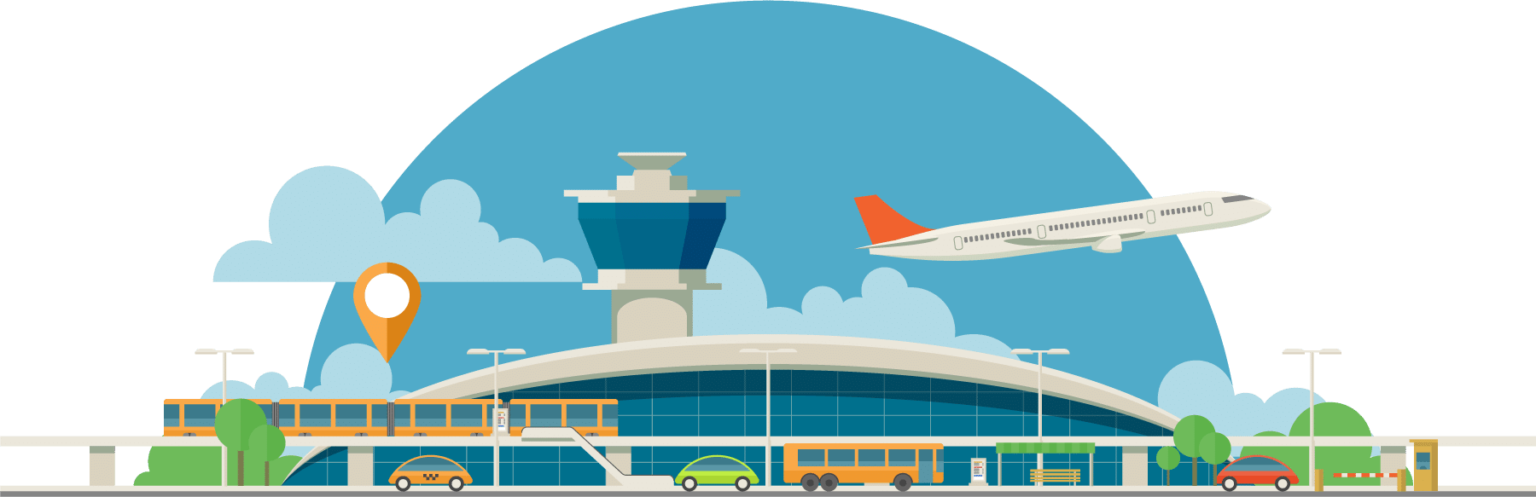

In [ ]:
# установка всех библиотек, необходимых для выполнения ДЗ

!pip install -q catboost mlxtend optuna lime shap missingno psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import shap
import lime.lime_tabular
import missingno
import missingno as msno

from sklearn.calibration import (
    calibration_curve,
    CalibratedClassifierCV,
    CalibrationDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
)
from sklearn.tree import (
    DecisionTreeClassifier,
    plot_tree,
    export_graphviz,
)
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
)
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    brier_score_loss,
    RocCurveDisplay,
)
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    chi2,
    mutual_info_classif,
    SequentialFeatureSelector,
    RFE,
    SelectFromModel,
)
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

from graphviz import Source
from IPython.display import SVG

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from tqdm import tqdm
import optuna

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

np.random.seed(42)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [ ]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-01-26 15:44:20--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2025-01-26 15:44:21 (872 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

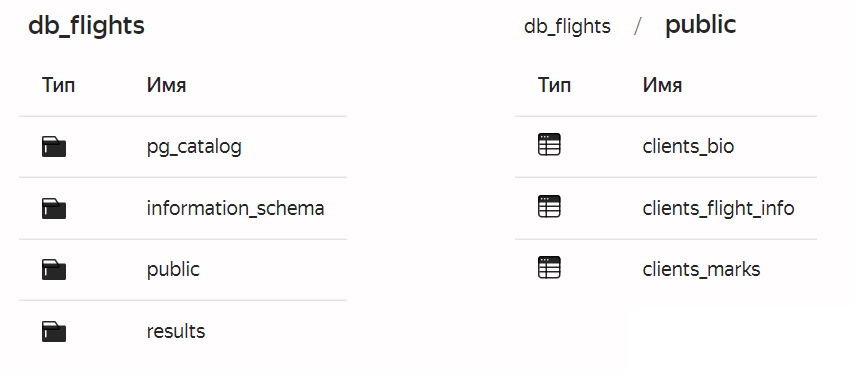



In [ ]:
connection_params = {
    "host": "rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
    "port": 6432,
    "sslmode": "verify-full",
    "dbname": "db_flights",
    "user": "mlhs_student",
    "password": "mlhs_student"
}

In [ ]:
query = """
SELECT
    table_name,
    column_name
FROM
    information_schema.columns
WHERE
    table_schema = 'public';
"""

try:
    with psycopg2.connect(**connection_params) as conn:
        with conn.cursor() as cursor:
            cursor.execute(query)
            data = cursor.fetchall()
            columns = [desc[0] for desc in cursor.description]
            df = pd.DataFrame(data, columns=columns)

except Exception as e:
    print(f"Ошибка подключения или выполнения запроса: {e}")

df

table_name                        column_name
0           student_predictions                         prediction
1   results.student_predictions                                 id
2   results.student_predictions                         prediction
3                 clients_marks                                 id
4           clients_flight_info                                 id
5                   clients_bio                                 id
6           student_predictions                                 id
7           student_predictions                              index
8                 clients_marks                    Online boarding
9                 clients_marks                       Seat comfort
10                clients_marks             Inflight entertainment
11                clients_marks                   On-board service
12                clients_marks                   Leg room service
13                clients_marks                   Baggage handling
14                clients_marks                    Checkin service
15                clients_marks                   Inflight service
16                clients_marks                        cleanliness
17                clients_marks                       satisfaction
18          clients_flight_info                      Customer Type
19          clients_flight_info                     Type of Travel
20          clients_flight_info                              class
21          clients_flight_info                    Flight Distance
22          clients_flight_info         Departure Delay in Minutes
23          clients_flight_info           Arrival Delay in Minutes
24                  clients_bio                             gender
25                  clients_bio                                age
26          student_predictions                            surname
27  results.student_predictions                            surname
28                clients_marks              Inflight wifi service
29                clients_marks  Departure/Arrival time convenient
30                clients_marks             Ease of Online booking
31                clients_marks                      Gate location
32                clients_marks                     Food and drink

In [ ]:
query = """
SELECT
    cb.id,
    cb.gender,
    cb.age,
    cfi."Customer Type",
    cfi."Type of Travel",
    cfi.class,
    cfi."Flight Distance",
    cfi."Departure Delay in Minutes",
    cfi."Arrival Delay in Minutes",
    cm."Inflight wifi service",
    cm."Departure/Arrival time convenient",
    cm."Ease of Online booking",
    cm."Gate location",
    cm."Food and drink",
    cm."Online boarding",
    cm."Seat comfort",
    cm."Inflight entertainment",
    cm."On-board service",
    cm."Leg room service",
    cm."Baggage handling",
    cm."Checkin service",
    cm."Inflight service",
    cm.cleanliness,
    cm.satisfaction
FROM
    public.clients_bio AS cb
JOIN
    public.clients_flight_info AS cfi ON cb.id = cfi.id
LEFT JOIN
    public.clients_marks AS cm ON cb.id = cm.id;
"""

try:
    with psycopg2.connect(**connection_params) as conn:
        with conn.cursor() as cursor:
            cursor.execute(query)
            data = cursor.fetchall()
            columns = [desc[0] for desc in cursor.description]
            df = pd.DataFrame(data, columns=columns).set_index("id")

except Exception as e:
    print(f"Ошибка подключения или выполнения запроса: {e}")

In [ ]:
# Вывод первых строк для проверки
df.head()

gender   age      Customer Type   Type of Travel     class  \
id                                                               
7     Male  43.0     Loyal Customer  Business travel  Business   
13    Male  24.0  disloyal Customer  Business travel       Eco   
18  Female  61.0     Loyal Customer  Personal Travel       Eco   
31    Male  35.0  disloyal Customer  Business travel  Business   
39  Female  46.0     Loyal Customer  Business travel  Business   

   Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
id                                                                       
7           1963.0                        0.0                      0.0   
13           453.0                       16.0                     30.0   
18           821.0                        0.0                      0.0   
31           212.0                        0.0                      0.0   
39            67.0                        0.0                      0.0   

   Inflight wifi service Departure/Arrival time convenient  ...  \
id                                                          ...   
7                    3.0                               3.0  ...   
13                   2.0                               2.0  ...   
18                   2.0                               5.0  ...   
31                   2.0                               2.0  ...   
39                   3.0                               3.0  ...   

   Online boarding Seat comfort Inflight entertainment On-board service  \
id                                                                        
7              4.0          5.0                    5.0              5.0   
13             2.0          5.0                    5.0              2.0   
18             1.0          5.0                    5.0              5.0   
31             2.0          2.0                    2.0              4.0   
39             5.0          4.0                    4.0              4.0   

   Leg room service Baggage handling Checkin service Inflight service  \
id                                                                      
7               5.0              5.0             4.0              5.0   
13              4.0              4.0             2.0              4.0   
18              2.0              5.0             5.0              5.0   
31              5.0              5.0             5.0              4.0   
39              4.0              4.0             5.0              4.0   

   cleanliness             satisfaction  
id                                       
7          4.0                satisfied  
13         5.0  neutral or dissatisfied  
18         1.0  neutral or dissatisfied  
31         2.0  neutral or dissatisfied  
39         5.0                satisfied  

[5 rows x 23 columns]

In [ ]:
df['Seat comfort'].unique()

array(['5.0', '2.0', '4.0', '3.0', '1.0', 'nan', '24.0', '15.0', '8.0',
       '9.0', '6.0', '20.0', '14.0', '0.0', '36.0', '18.0', '27.0',
       '10.0', '16.0', '12.0', '45.0', '30.0'], dtype=object)

In [ ]:
# Замена на настояий nan
df = df.replace('nan', np.nan)

In [ ]:
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [ ]:
def can_convert_to_numeric(series):
    """
    Проверяет, можно ли преобразовать значения столбца в числовой тип (с учетом NaN)
    """
    try:
        pd.to_numeric(series.str.replace(',', '.', regex=False).dropna(), errors='raise')
        return True
    except ValueError:
        return False

# Преобразование столбцов, которые можно перевести в числовой формат
for col in df.columns:
    if can_convert_to_numeric(df[col]):
        df[col] = pd.to_numeric(df[col], errors='coerce')
    else:
        print(f"Столбец '{col}' нельзя преобразовать в числовой формат.")

Столбец 'gender' нельзя преобразовать в числовой формат.
Столбец 'Customer Type' нельзя преобразовать в числовой формат.
Столбец 'Type of Travel' нельзя преобразовать в числовой формат.
Столбец 'class' нельзя преобразовать в числовой формат.
Столбец 'satisfaction' нельзя преобразовать в числовой формат.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             129549 non-null  object 
 1   age                                129234 non-null  float64
 2   Customer Type                      129472 non-null  object 
 3   Type of Travel                     129448 non-null  object 
 4   class                              129433 non-null  object 
 5   Flight Distance                    129455 non-null  float64
 6   Departure Delay in Minutes         129442 non-null  float64
 7   Arrival Delay in Minutes           129042 non-null  float64
 8   Inflight wifi service              129505 non-null  float64
 9   Departure/Arrival time convenient  129500 non-null  float64
 10  Ease of Online booking             129506 non-null  float64
 11  Gate location                      129512 no

In [ ]:
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
print("Пропуски (в процентах):")
print(missing_percent[missing_percent > 0].sort_values(ascending=False))

Пропуски (в процентах):
Arrival Delay in Minutes             0.391358
age                                  0.243151
class                                0.089541
Departure Delay in Minutes           0.082594
Type of Travel                       0.077963
Flight Distance                      0.072559
Customer Type                        0.059437
Inflight service                     0.048630
Food and drink                       0.038595
Departure/Arrival time convenient    0.037824
Baggage handling                     0.037052
Seat comfort                         0.036280
Online boarding                      0.035508
Leg room service                     0.035508
Inflight entertainment               0.034736
Inflight wifi service                0.033964
On-board service                     0.033964
Ease of Online booking               0.033192
Checkin service                      0.032420
Gate location                        0.028561
cleanliness                          0.028561
dtype: flo

In [ ]:
numeric_columns = df.select_dtypes(include=['number']).columns

# Проверка выбросов с использованием IQR
def detect_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[col] < lower_bound) | (df[col] > upper_bound)]

outliers_report = {}
for col in numeric_columns:
    outliers = detect_outliers(df, col)
    outliers_count = len(outliers)
    if outliers_count > 0:
        outliers_report[col] = outliers_count

print("Выбросы в числовых столбцах:")
for col, count in outliers_report.items():
    print(f"{col}: {count} выбросов")

Выбросы в числовых столбцах:
age: 448 выбросов
Flight Distance: 3074 выбросов
Departure Delay in Minutes: 18124 выбросов
Arrival Delay in Minutes: 17499 выбросов
Inflight wifi service: 24 выбросов
Departure/Arrival time convenient: 35 выбросов
Ease of Online booking: 29 выбросов
Gate location: 39 выбросов
Food and drink: 28 выбросов
Online boarding: 32 выбросов
Seat comfort: 34 выбросов
Inflight entertainment: 23 выбросов
On-board service: 26 выбросов
Leg room service: 39 выбросов
Baggage handling: 27 выбросов
Checkin service: 16103 выбросов
Inflight service: 39 выбросов
cleanliness: 25 выбросов


### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

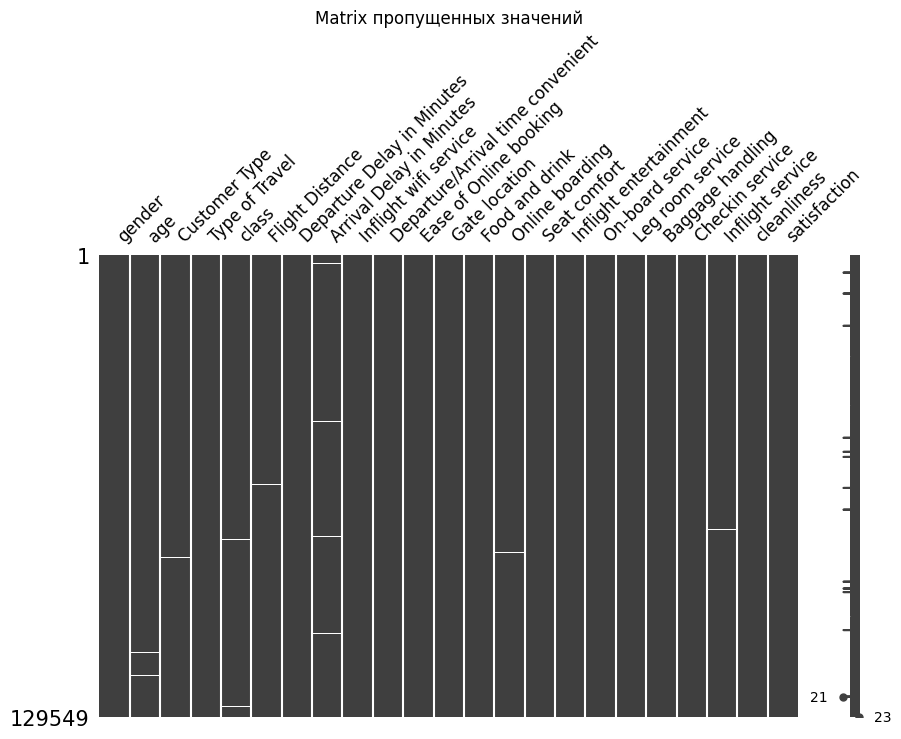

In [ ]:
# матрицa пропущенных значений
msno.matrix(df, figsize=(10, 6), fontsize=12)
plt.title("Matrix пропущенных значений")
plt.show();

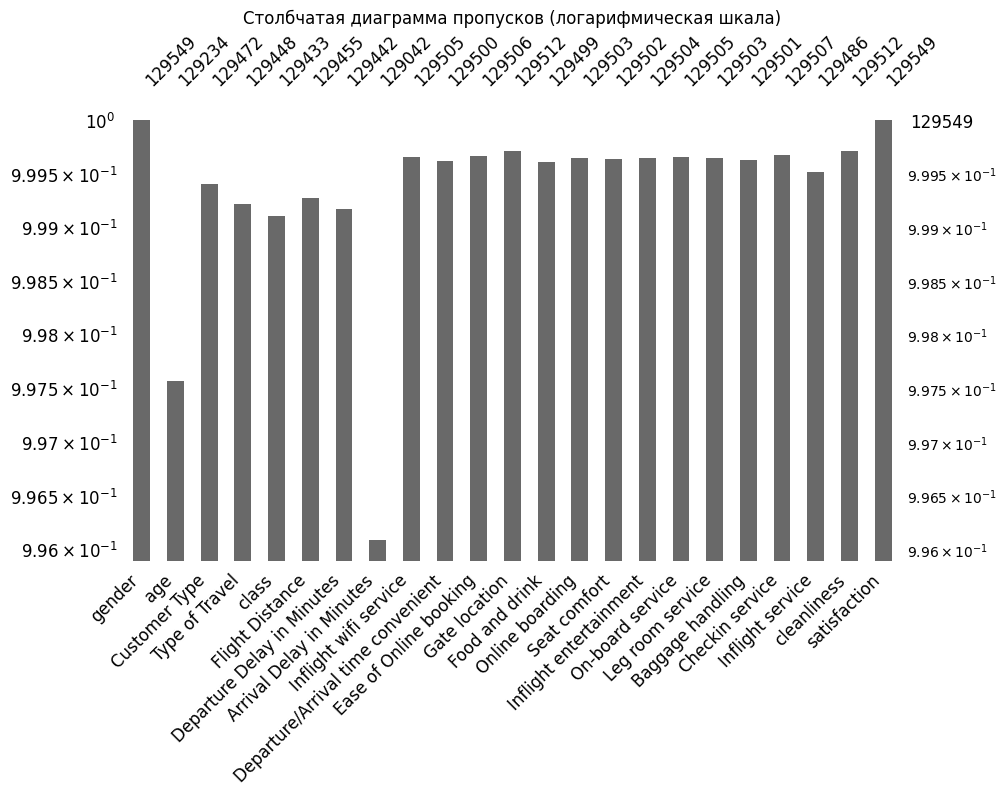

In [ ]:
# столбчатая диаграммa пропусков в логарифмированной шкале
msno.bar(df, figsize=(10, 6), log=True, fontsize=12)
plt.title("Столбчатая диаграмма пропусков (логарифмическая шкала)")
plt.show();

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [ ]:
df_train = df[df.satisfaction != '-']
df_train

gender   age      Customer Type   Type of Travel     class  \
id                                                                   
7         Male  43.0     Loyal Customer  Business travel  Business   
13        Male  24.0  disloyal Customer  Business travel       Eco   
18      Female  61.0     Loyal Customer  Personal Travel       Eco   
31        Male  35.0  disloyal Customer  Business travel  Business   
39      Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129831  Female  28.0     Loyal Customer  Personal Travel       Eco   
129837    Male  66.0     Loyal Customer  Personal Travel       Eco   
129838  Female  59.0     Loyal Customer  Personal Travel       Eco   
129839    Male  61.0     Loyal Customer  Personal Travel       Eco   
129846    Male  44.0     Loyal Customer  Personal Travel       Eco   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
7                1963.0                         0.0                       0.0   
13                453.0                        16.0                      30.0   
18                821.0                         0.0                       0.0   
31                212.0                         0.0                       0.0   
39                 67.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129831            447.0                        23.0                      16.0   
129837            337.0                       199.0                     213.0   
129838            308.0                        32.0                      24.0   
129839            337.0                         0.0                       0.0   
129846            447.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
7                         3.0                                3.0  ...   
13                        2.0                                2.0  ...   
18                        2.0                                5.0  ...   
31                        2.0                                2.0  ...   
39                        3.0                                3.0  ...   
...                       ...                                ...  ...   
129831                    1.0                                3.0  ...   
129837                    2.0                                4.0  ...   
129838                    3.0                                5.0  ...   
129839                    2.0                                4.0  ...   
129846                    2.0                                5.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
7                   4.0           5.0                     5.0   
13                  2.0           5.0                     5.0   
18                  1.0           5.0                     5.0   
31                  2.0           2.0                     2.0   
39                  5.0           4.0                     4.0   
...                 ...           ...                     ...   
129831              1.0           3.0                     3.0   
129837              5.0           5.0                     5.0   
129838              5.0           5.0                     3.0   
129839              2.0           3.0                     3.0   
129846              2.0           5.0                     5.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
id                                                                              
7                    5.0               5.0               5.0              4.0   
13  

In [ ]:
assert df_train.shape == (103_644, 23)

In [ ]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

gender   age   Customer Type   Type of Travel     class  \
id                                                                
55        Male  36.0  Loyal Customer  Business travel  Business   
79      Female  70.0  Loyal Customer  Personal Travel       Eco   
126       Male  66.0  Loyal Customer  Personal Travel       Eco   
199     Female  60.0  Loyal Customer  Business travel  Business   
263       Male  43.0  Loyal Customer  Personal Travel  Business   
...        ...   ...             ...              ...       ...   
129750    Male  38.0  Loyal Customer  Business travel       Eco   
129771    Male  16.0  Loyal Customer  Personal Travel       Eco   
129798  Female  43.0  Loyal Customer  Personal Travel       Eco   
129868    Male  47.0  Loyal Customer  Business travel  Eco Plus   
129876    Male  28.0  Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
55               3655.0                        40.0                      71.0   
79                108.0                        50.0                      41.0   
126               562.0                        88.0                      84.0   
199              3756.0                        36.0                      24.0   
263               802.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129750            337.0                        92.0                      82.0   
129771            308.0                         2.0                       0.0   
129798            308.0                         0.0                       0.0   
129868            447.0                         0.0                       0.0   
129876            447.0                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
55                        1.0                                1.0  ...   
79                        5.0                                4.0  ...   
126                       2.0                                5.0  ...   
199                       4.0                                4.0  ...   
263                       1.0                                2.0  ...   
...                       ...                                ...  ...   
129750                    4.0                                3.0  ...   
129771                    3.0                                4.0  ...   
129798                    2.0                                4.0  ...   
129868                    3.0                                4.0  ...   
129876                    4.0                                4.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
id                                                                              
55                 1.0              3.0           3.0                     3.0   
79                 4.0              4.0           4.0                     3.0   
126                5.0              2.0           5.0                     5.0   
199                2.0              4.0           5.0                     4.0   
263                2.0              3.0           3.0                     2.0   
...                ...              ...           ...                     ...   
129750             4.0              5.0           4.0                     4.0   
129771             1.0              3.0           5.0                     1.0   
129798             3.0              5.0           5.0                     4.0   
129868             4.0              3.0           4.0                     4.0   
129876             4.0              4.0           1.0                     4.0   

        On-board service  Leg room service  Baggage handling  Checkin service 

In [ ]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [ ]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [ ]:
def fill_missing_with_mode(df):
    for col in df.columns:
        if df[col].isnull().any():
            # Заполнение пропусков модой
            mode_value = df[col].mode()[0]
            df[col].fillna(mode_value, inplace=True)
    return df

# Заполнение пропусков в тренировочном и валидационном наборах
X_train = fill_missing_with_mode(X_train)
X_val = fill_missing_with_mode(X_val)

print("Пропуски в X_train после заполнения:")
print(X_train.isnull().sum().sum())

print("Пропуски в X_val после заполнения:")
print(X_val.isnull().sum().sum())

Пропуски в X_train после заполнения:
0
Пропуски в X_val после заполнения:
0


### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [ ]:
# Статистики для числовых столбцов
numeric_columns = X_train.select_dtypes(include=['number']).columns
numeric_stats = X_train[numeric_columns].describe()
print("Статистики для числовых столбцов:")
numeric_stats.T

Статистики для числовых столбцов:


count         mean          std  min  \
age                                72550.0    40.098856    20.658196  0.0   
Flight Distance                    72550.0  1329.018332  4764.369357  0.0   
Departure Delay in Minutes         72550.0    15.859366    70.861937  0.0   
Arrival Delay in Minutes           72550.0    16.645968    97.990293  0.0   
Inflight wifi service              72550.0     2.733687     1.362172  0.0   
Departure/Arrival time convenient  72550.0     3.065017     1.552254  0.0   
Ease of Online booking             72550.0     2.761006     1.414843  0.0   
Gate location                      72550.0     2.982688     1.316648  0.0   
Food and drink                     72550.0     3.209318     1.349963  0.0   
Online boarding                    72550.0     3.256513     1.372739  0.0   
Seat comfort                       72550.0     3.445665     1.346077  0.0   
Inflight entertainment             72550.0     3.362150     1.360862  0.0   
On-board service                   72550.0     3.383101     1.333758  0.0   
Leg room service                   72550.0     3.352364     1.360180  0.0   
Baggage handling                   72550.0     3.630255     1.227853  0.0   
Checkin service                    72550.0     3.309056     1.293114  0.0   
Inflight service                   72550.0     3.640234     1.215114  0.0   
cleanliness                        72550.0     3.291178     1.343302  0.0   

                                     25%    50%     75%       max  
age                                 27.0   40.0    51.0     544.0  
Flight Distance                    413.0  844.0  1744.0  379620.0  
Departure Delay in Minutes           0.0    0.0    12.0    9282.0  
Arrival Delay in Minutes             0.0    0.0    13.0   11760.0  
Inflight wifi service                2.0    3.0     4.0      45.0  
Departure/Arrival time convenient    2.0    3.0     4.0      45.0  
Ease of Online booking               2.0    3.0     4.0      28.0  
Gate location                        2.0    3.0     4.0      36.0  
Food and drink                       2.0    3.0     4.0      36.0  
Online boarding                      2.0    3.0     4.0      32.0  
Seat comfort                         2.0    4.0     5.0      45.0  
Inflight entertainment               2.0    4.0     4.0      40.0  
On-board service                     2.0    4.0     4.0      45.0  
Leg room service                     2.0    4.0     4.0      36.0  
Baggage handling                     3.0    4.0     5.0      40.0  
Checkin service                      3.0    3.0     4.0      45.0  
Inflight service                     3.0    4.0     5.0      36.0  
cleanliness                          2.0    3.0     4.0      45.0

In [ ]:
# Статистики для категориальных столбцов
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
categorical_stats = X_train[categorical_columns].describe()
print("\nСтатистики для категориальных столбцов:")
categorical_stats.T


Статистики для категориальных столбцов:


count unique              top   freq
gender          72550      2           Female  36816
Customer Type   72550      2   Loyal Customer  59406
Type of Travel  72550      2  Business travel  50054
class           72550      3         Business  34793

In [ ]:
print("\nАнализ распределений признаков:")

# Анализ числовых признаков
for col in numeric_columns:
    print(f"\nЧисловой признак: {col}")
    print(f"Среднее: {X_train[col].mean():.2f}, медиана: {X_train[col].median():.2f}")
    print(f"Минимум: {X_train[col].min()}, максимум: {X_train[col].max()}")
    print(f"Распределение: {'симметричное' if abs(X_train[col].skew()) < 0.5 else 'асимметричное'}")

# Анализ категориальных признаков
for col in categorical_columns:
    print(f"\nКатегориальный признак: {col}")
    top_category = X_train[col].mode()[0]
    top_freq = X_train[col].value_counts().iloc[0]
    print(f"Наиболее частое значение: {top_category} (встречается {top_freq} раз)")
    print(f"Количество уникальных категорий: {X_train[col].nunique()}")


Анализ распределений признаков:

Числовой признак: age
Среднее: 40.10, медиана: 40.00
Минимум: 0.0, максимум: 544.0
Распределение: асимметричное

Числовой признак: Flight Distance
Среднее: 1329.02, медиана: 844.00
Минимум: 0.0, максимум: 379620.0
Распределение: асимметричное

Числовой признак: Departure Delay in Minutes
Среднее: 15.86, медиана: 0.00
Минимум: 0.0, максимум: 9282.0
Распределение: асимметричное

Числовой признак: Arrival Delay in Minutes
Среднее: 16.65, медиана: 0.00
Минимум: 0.0, максимум: 11760.0
Распределение: асимметричное

Числовой признак: Inflight wifi service
Среднее: 2.73, медиана: 3.00
Минимум: 0.0, максимум: 45.0
Распределение: асимметричное

Числовой признак: Departure/Arrival time convenient
Среднее: 3.07, медиана: 3.00
Минимум: 0.0, максимум: 45.0
Распределение: симметричное

Числовой признак: Ease of Online booking
Среднее: 2.76, медиана: 3.00
Минимум: 0.0, максимум: 28.0
Распределение: симметричное

Числовой признак: Gate location
Среднее: 2.98, медиана: 

Вывод

1. Числовые признаки:

* Возраст (age):

Среднее значение: 40.1 года, медиана: 40.0 года.
Минимальное значение: 0 (возможно, ошибочные данные), максимальное значение: 544 (явно выброс).
Распределение сильно асимметричное из-за выбросов.

* Расстояние полета (Flight Distance):

Среднее: 1329.02, медиана: 844.
Максимальное значение 379620 также является явным выбросом.
Распределение асимметричное.

* Задержки (Departure Delay in Minutes, Arrival Delay in Minutes):

Средние значения: 15.86 и 16.65 минут, медиана: 0.
Значения варьируются от 0 до 9282 и 11760 минут, что также указывает на выбросы.
Распределение асимметричное.

* Оценки обслуживания (Inflight wifi service, Ease of Online booking, и т. д.):

Большинство оценок варьируется от 0 до 5, однако встречаются значения до 45, что указывает на выбросы.
Распределения в основном симметричные для большинства признаков.


2. Категориальные признаки:

* Пол (gender):

Две категории: Female (самая частая) и Male.
Распределение сбалансированное.

* Тип клиента (Customer Type):

Две категории: Loyal Customer и Disloyal Customer.
Большинство клиентов — лояльные (59406 записей).

* Тип поездки (Type of Travel):

Две категории: Business travel и Personal Travel.
Бизнес-поездки встречаются чаще.

* Класс (class):

Три категории: Business, Eco, Eco Plus.
Business является наиболее популярным.



Необходимо обработать явные выбросы.
Учитывать дисбаланс в категориальных признаках при обучении модели (например, gender и Customer Type).

`Ваш ответ здесь`

### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [ ]:
def remove_outliers(df, numeric_columns, quantile=0.996):
    # Вычисляем границы для каждого числового столбца
    thresholds = {col: df[col].quantile(quantile) for col in numeric_columns}

    # Фильтруем строки, где значения не превышают заданный квантиль
    for col, threshold in thresholds.items():
        df = df[df[col] <= threshold]
    return df

# Удаляем выбросы из X_train
numeric_columns = X_train.select_dtypes(include=['number']).columns
X_train_no_target = X_train.drop(columns=["satisfaction"], errors="ignore")
X_train_no_target = remove_outliers(X_train_no_target, numeric_columns)
X_train = X_train_no_target
y_train = y_train.loc[X_train.index]

X_val_no_target = X_val.drop(columns=["satisfaction"], errors="ignore")
X_val_no_target = remove_outliers(X_val_no_target, numeric_columns)
X_val = X_val_no_target
y_val = y_val.loc[X_val.index]

# Проверяем размеры после удаления выбросов
print(f"Размер X_train после удаления выбросов: {X_train.shape}")
print(f"Размер y_train после удаления выбросов: {y_train.shape}")
print(f"Размер X_val после удаления выбросов: {X_val.shape}")
print(f"Размер y_val после удаления выбросов: {y_val.shape}")

Размер X_train после удаления выбросов: (71395, 22)
Размер y_train после удаления выбросов: (71395,)
Размер X_val после удаления выбросов: (30588, 22)
Размер y_val после удаления выбросов: (30588,)


In [ ]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [ ]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes',
                   'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [ ]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [ ]:
# Графики для порядковых признаков
def plot_ordinal(cols, df, y):
    for col in cols:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=col, hue=y, palette="viridis")
        plt.title(f"Распределение признака {col} по таргету")
        plt.xlabel(col)
        plt.ylabel("Количество")
        plt.legend(title="Таргет", loc="upper right")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Графики для континуальных признаков
def plot_continuous(cols, df, y):
    for col in cols:
        plt.figure(figsize=(15, 6))

        # Гистограмма распределения с разделением по таргету
        plt.subplot(1, 2, 1)
        sns.kdeplot(data=df, x=col, hue=y, fill=True, palette="viridis", common_norm=False)
        plt.title(f"Гистограмма распределения признака {col}")
        plt.xlabel(col)
        plt.ylabel("Плотность")
        plt.legend(title="Таргет")

        # Ящик с усами
        plt.subplot(1, 2, 2)
        sns.boxplot(data=df, x=y, y=col, palette="viridis")
        plt.title(f"Распределение признака {col} по таргету (ящик с усами)")
        plt.xlabel("Таргет")
        plt.ylabel(col)

        plt.tight_layout()
        plt.show()

# Графики для категориальных признаков
def plot_categorical(cols, df, y):
    for col in cols:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=col, hue=y, palette="viridis")
        plt.title(f"Распределение признака {col} по таргету")
        plt.xlabel(col)
        plt.ylabel("Количество")
        plt.legend(title="Таргет", loc="upper right")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

Отрисовка.

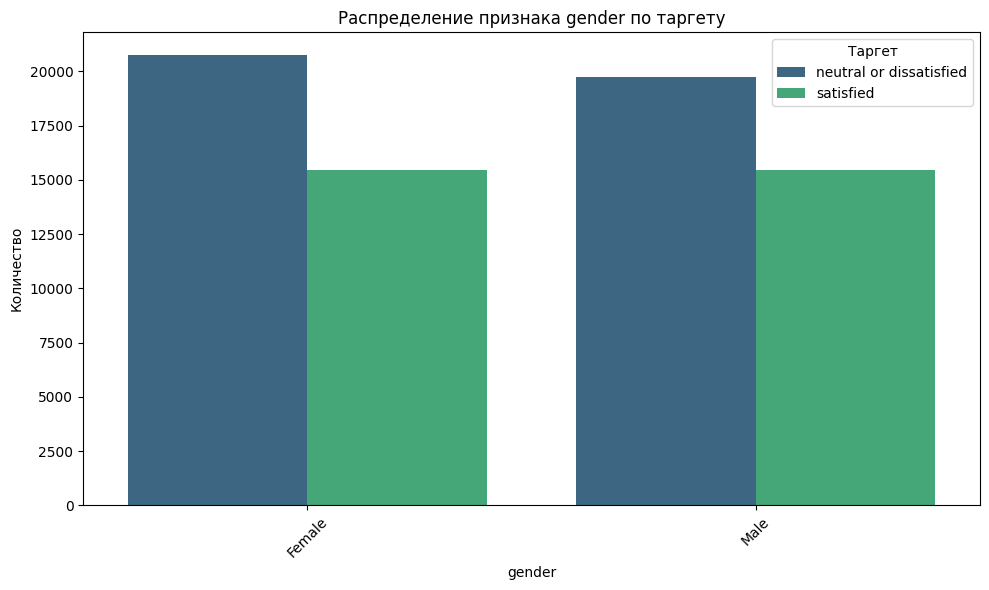

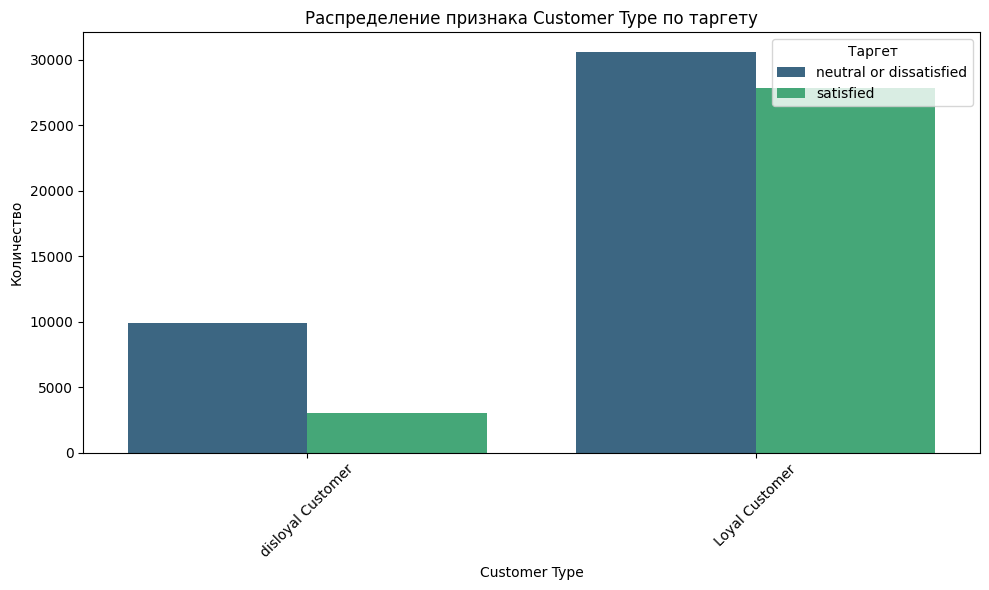

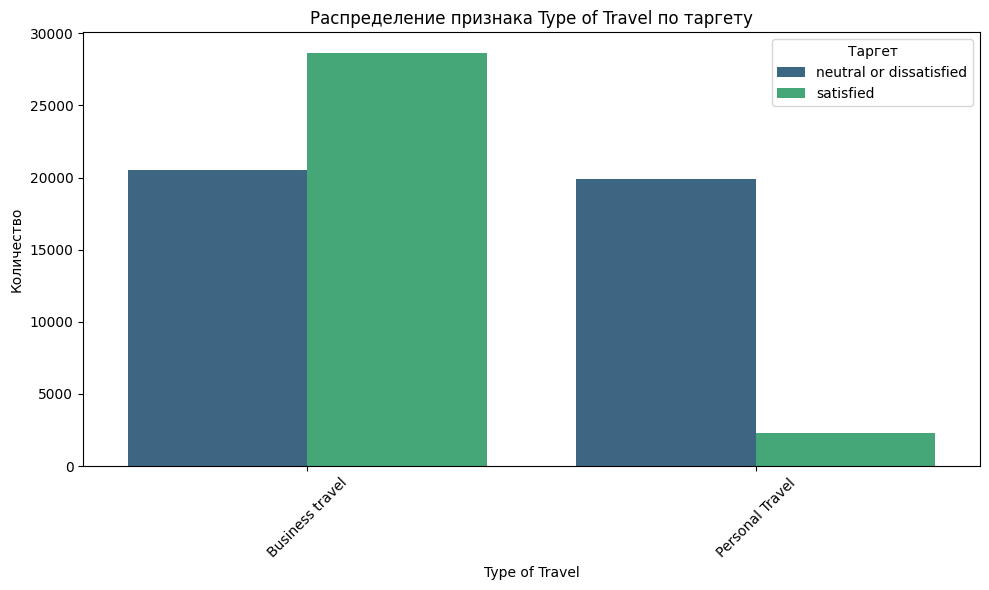

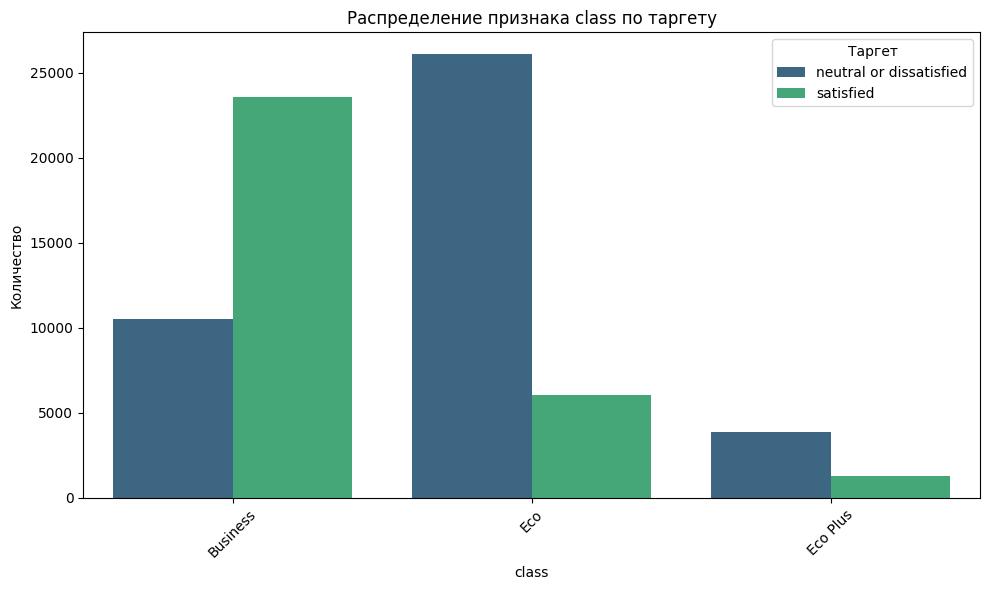

In [ ]:
plot_categorical(categorical_cols, X_train, y_train)

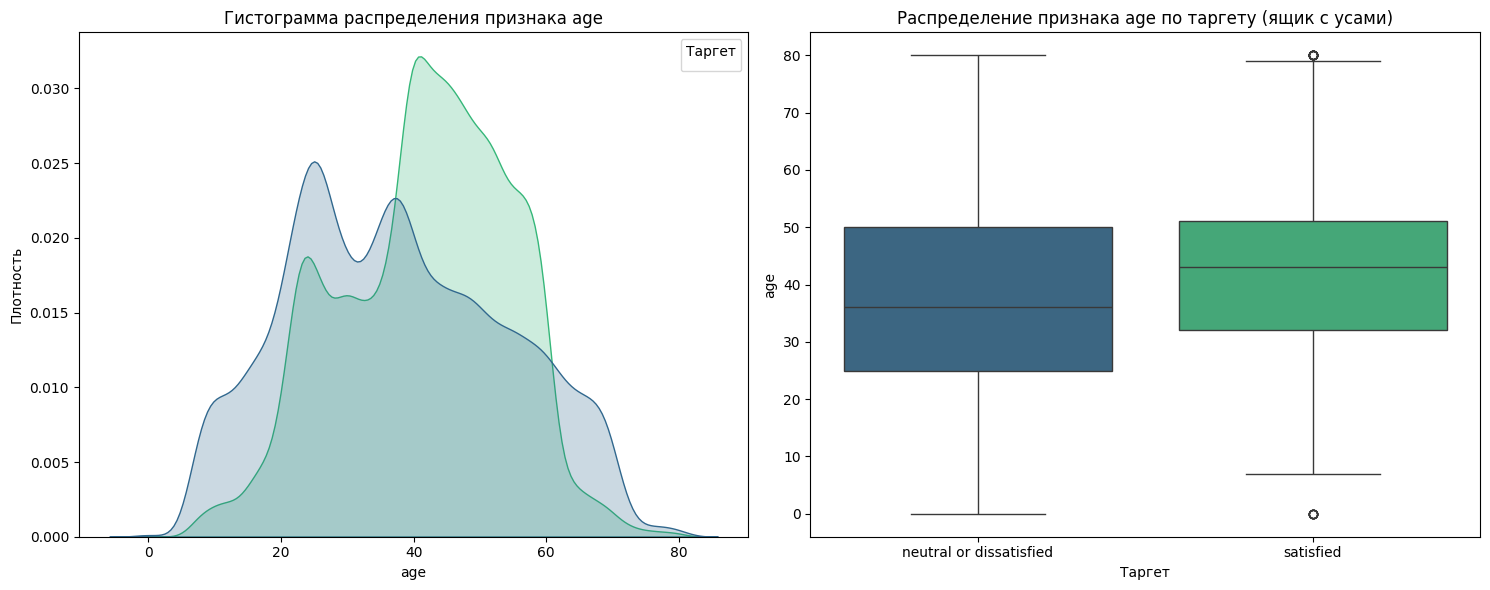

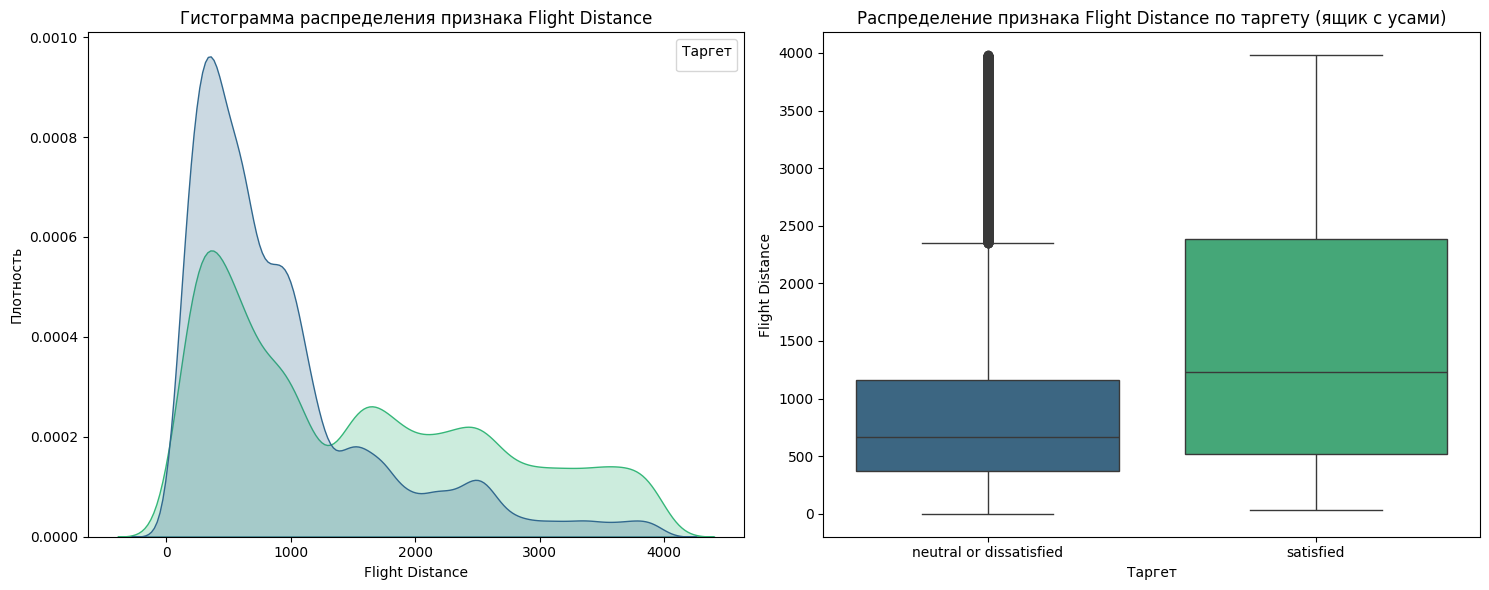

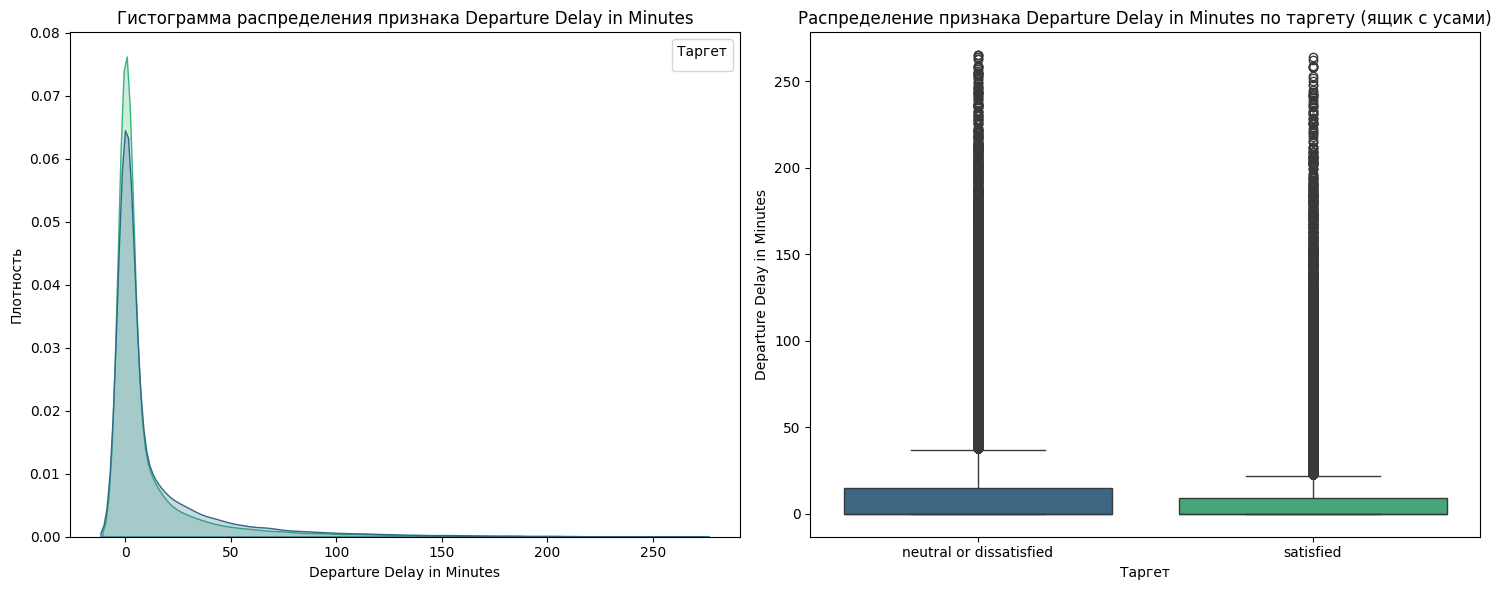

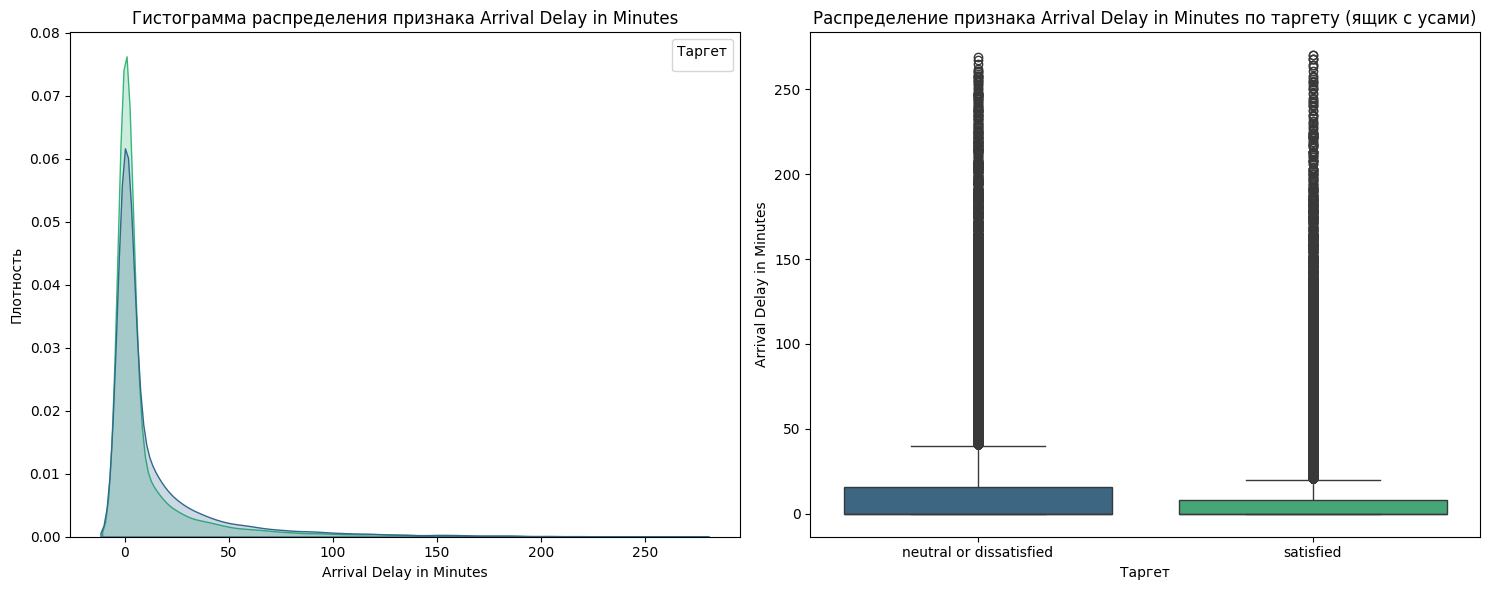

In [ ]:
plot_continuous(continuous_cols, X_train, y_train)

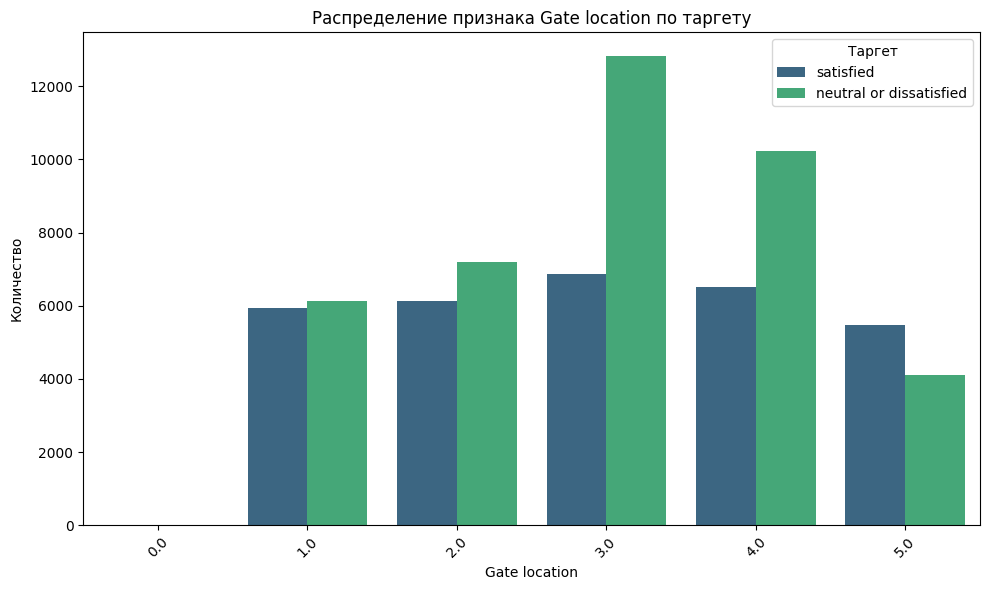

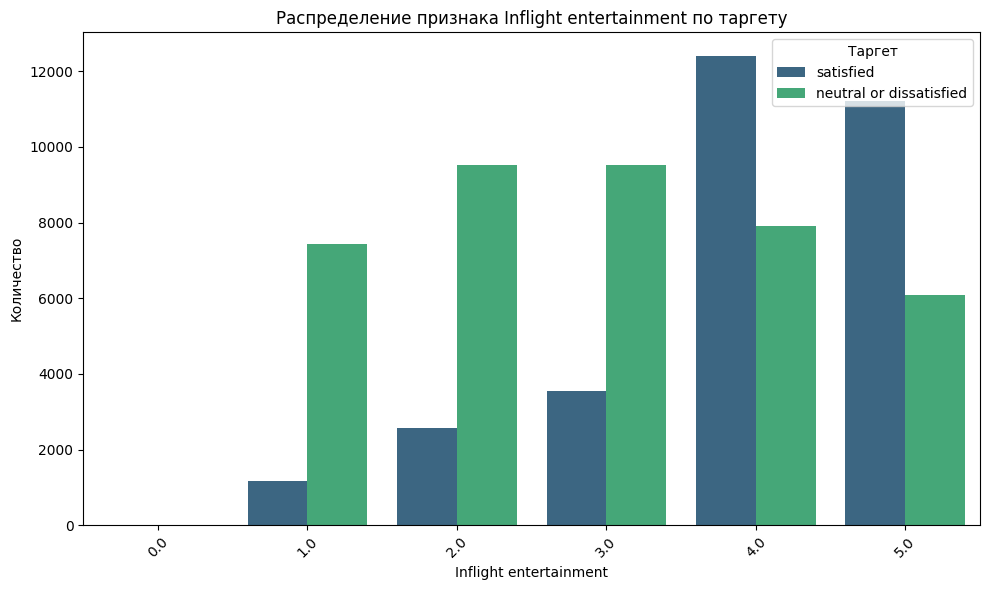

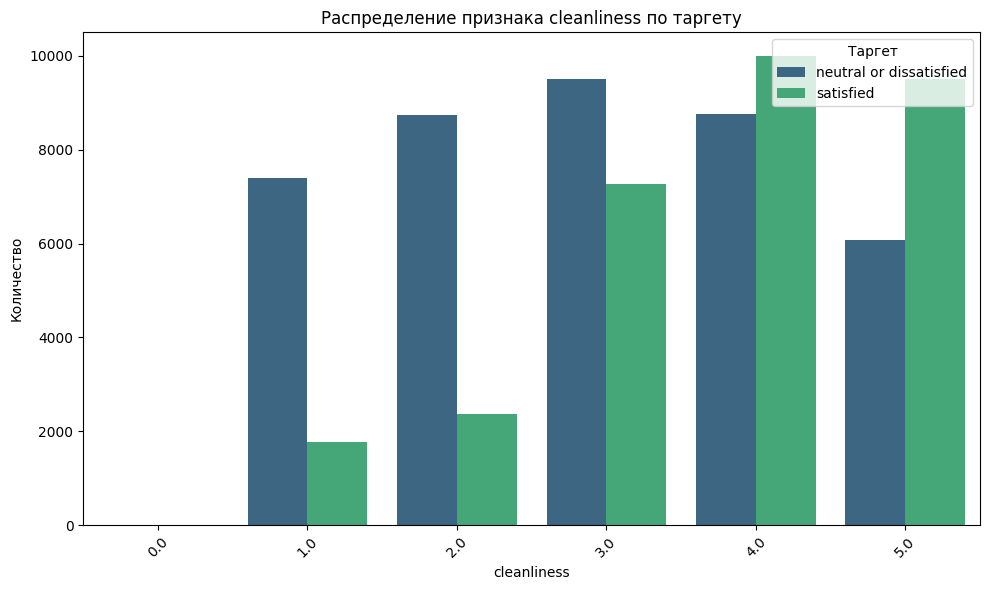

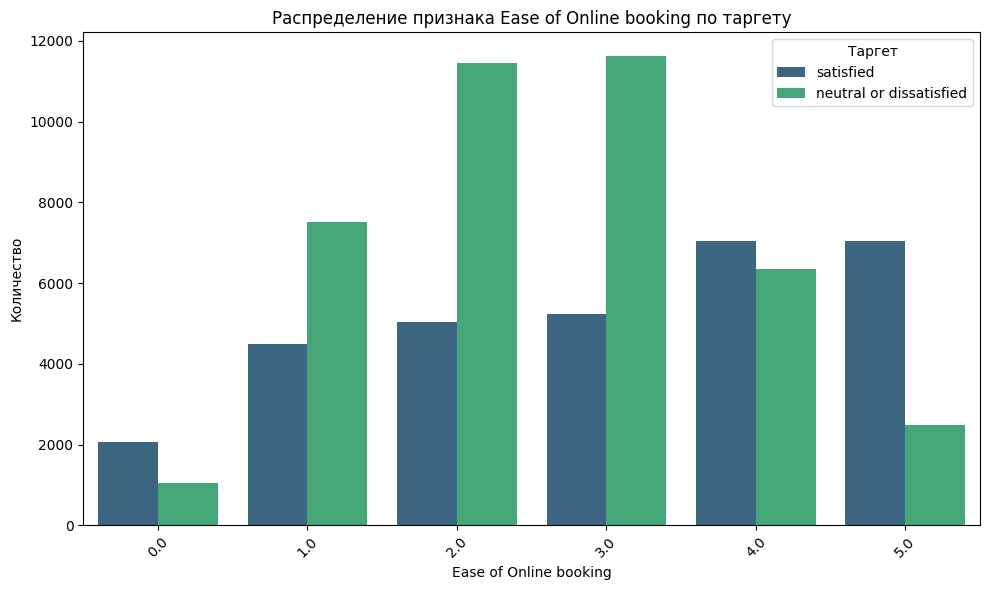

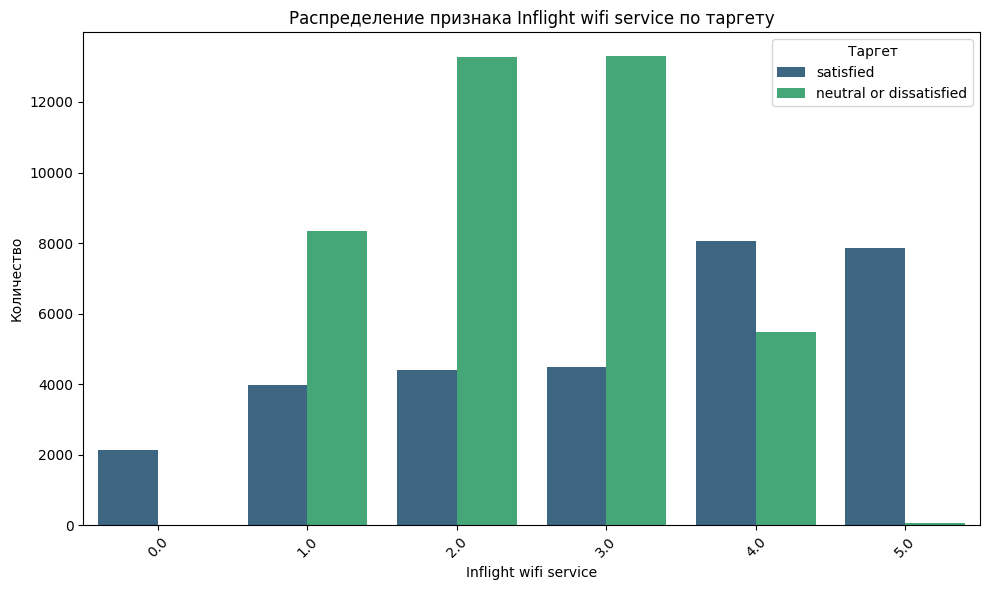

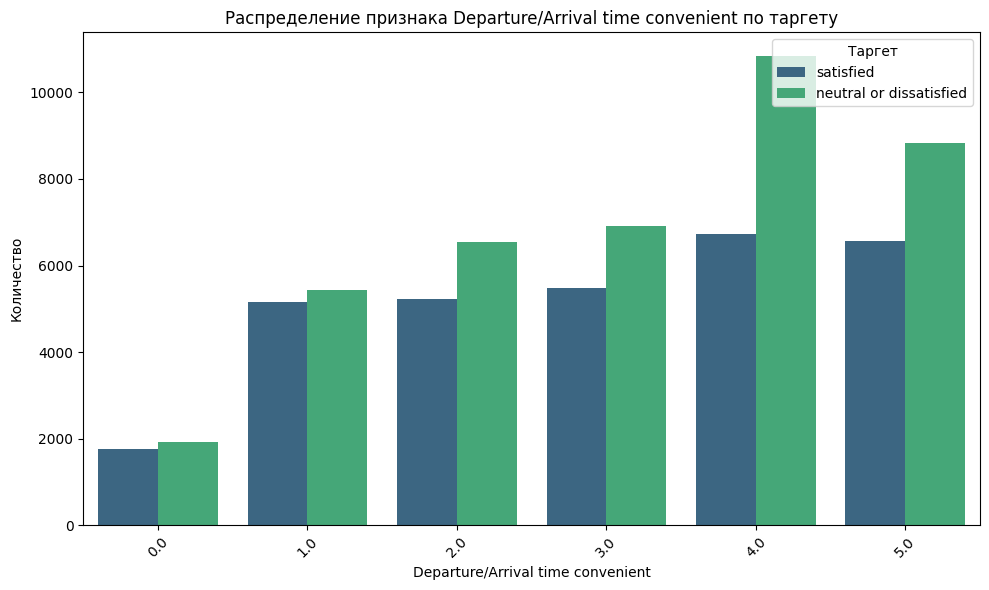

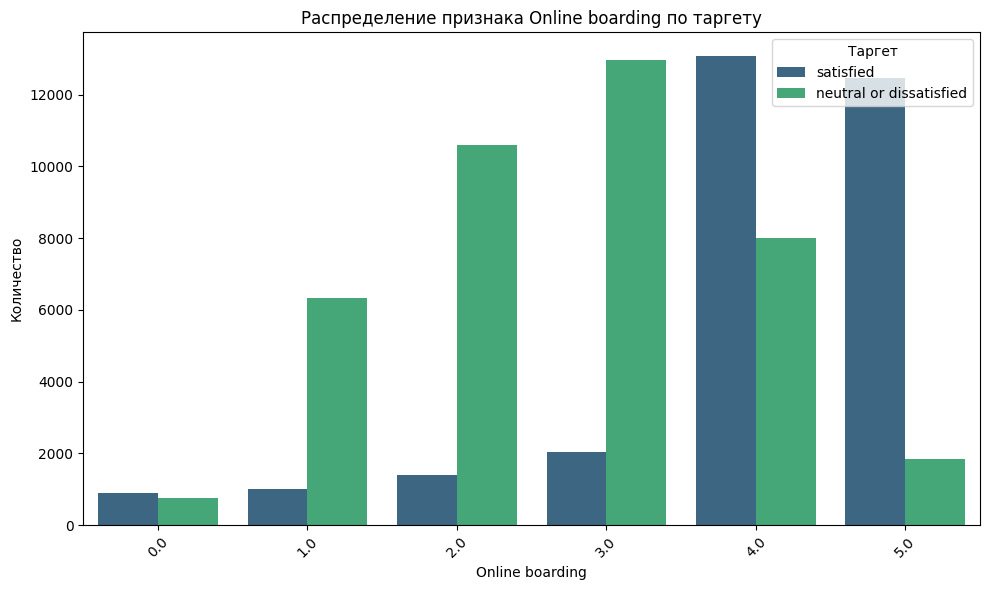

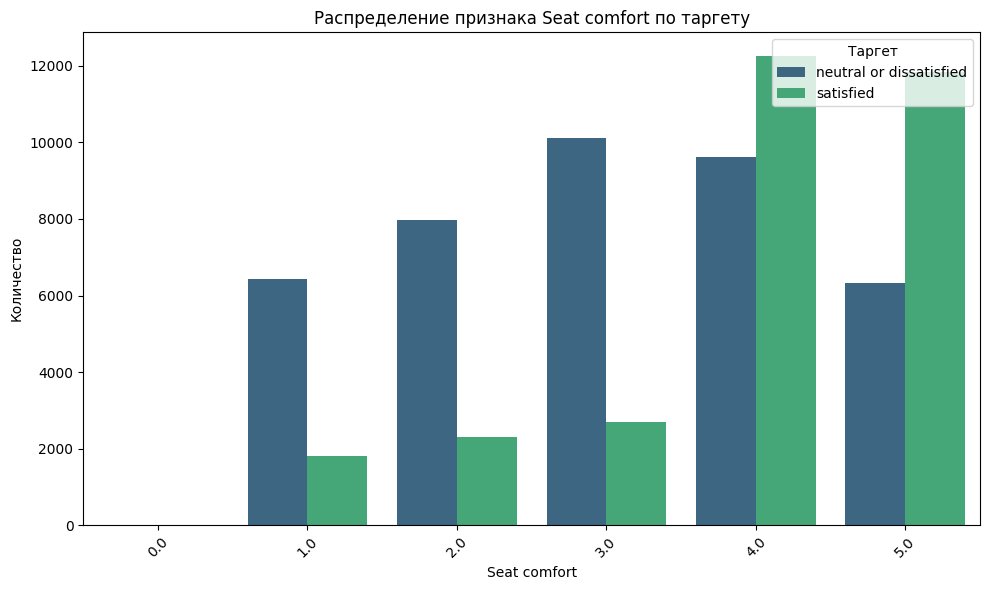

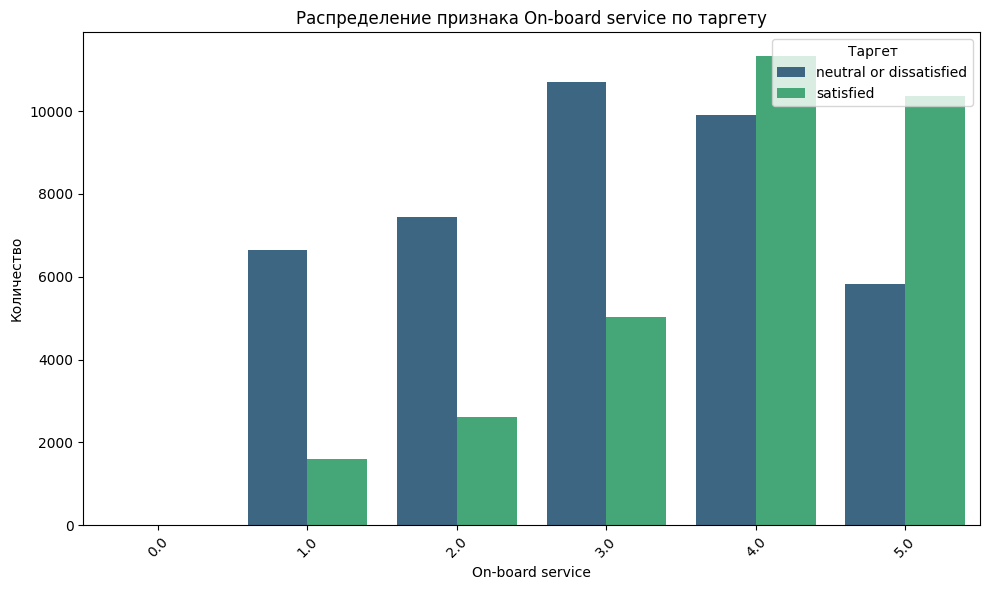

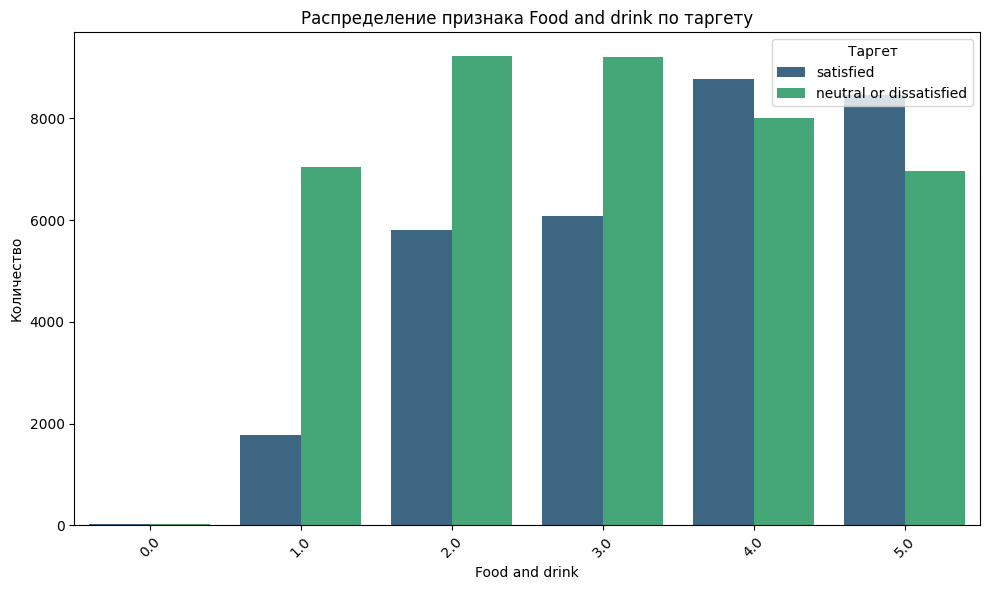

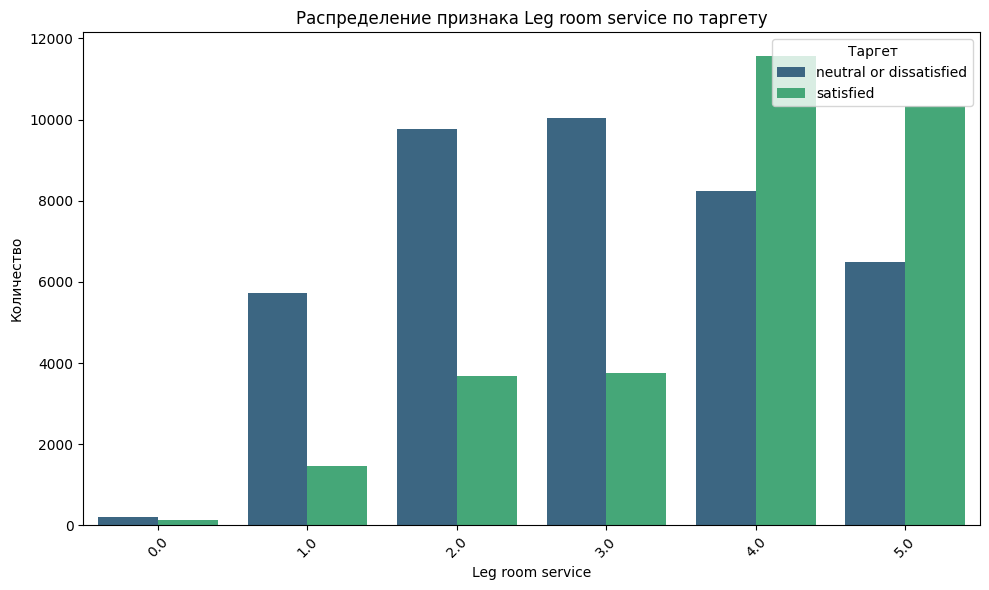

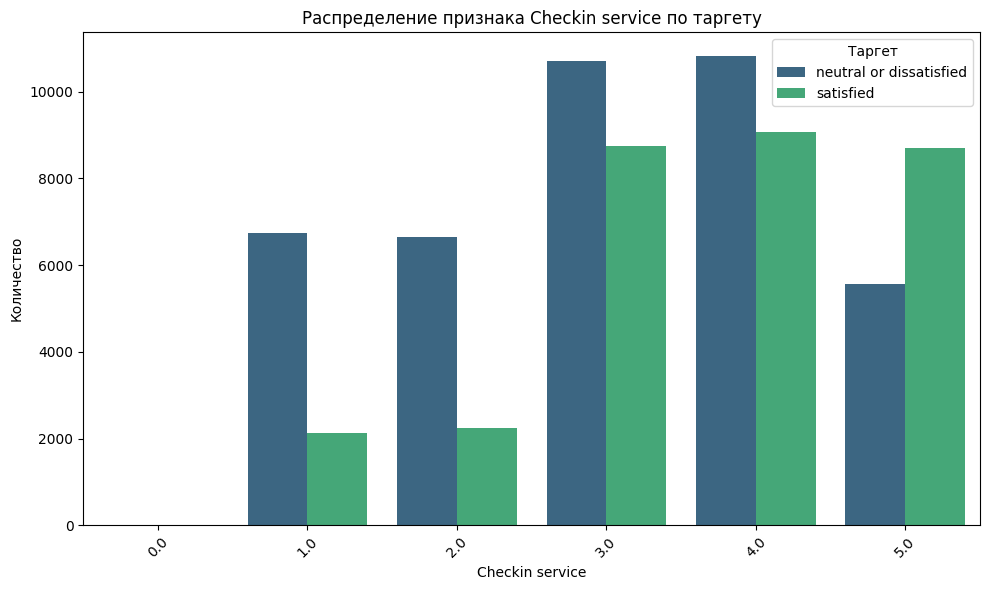

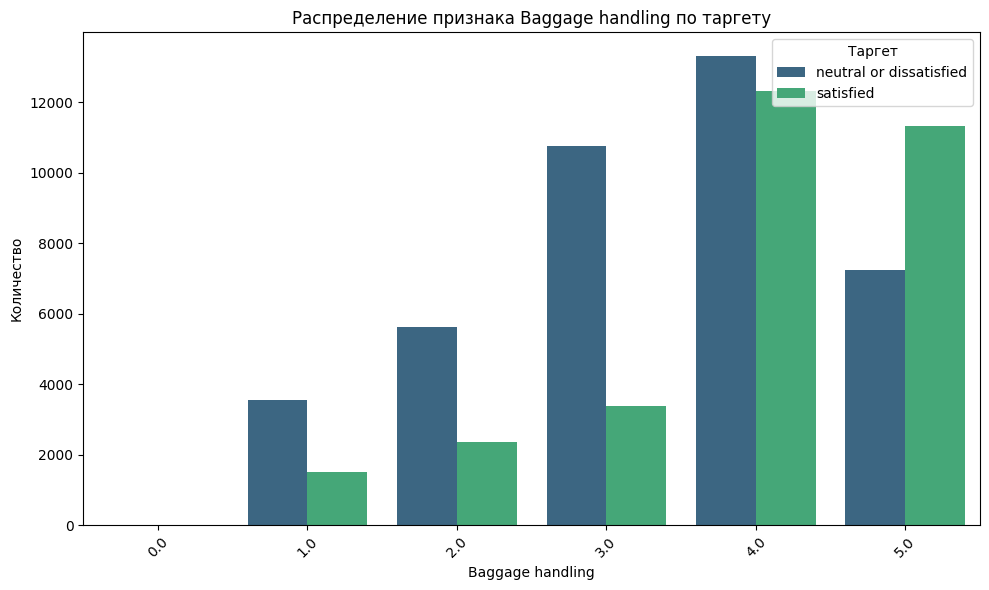

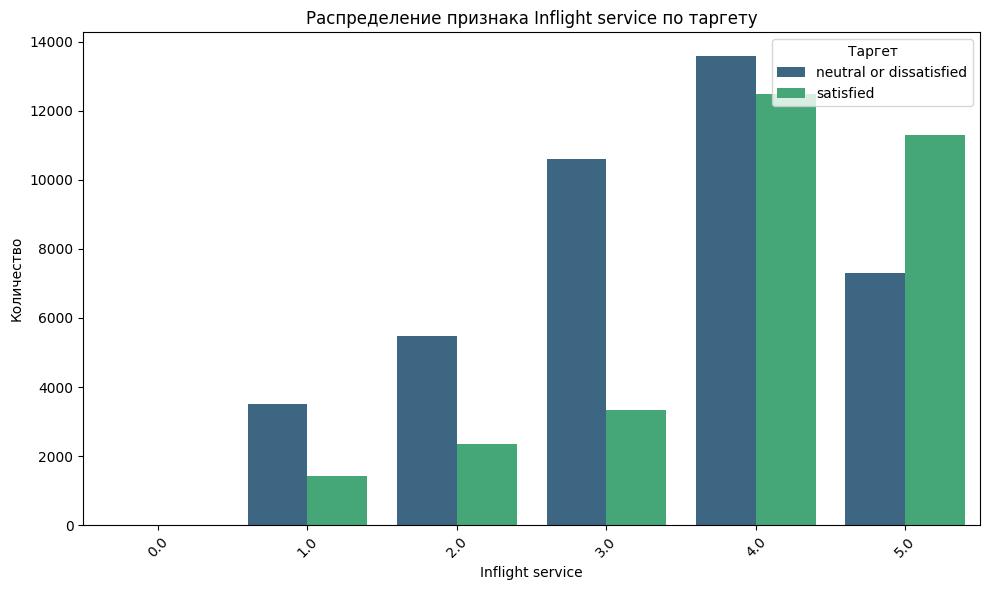

In [ ]:
plot_ordinal(ordinal_cols, X_train, y_train)

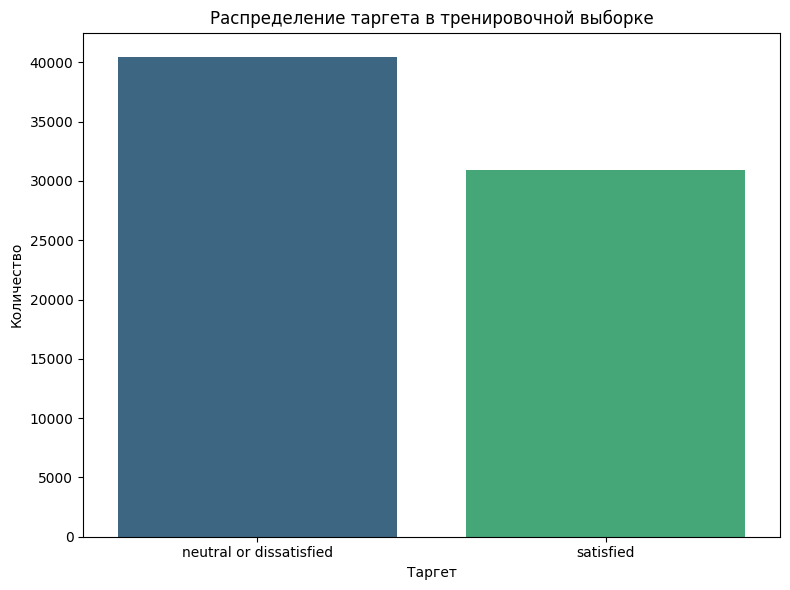

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train, palette="viridis")
plt.title("Распределение таргета в тренировочной выборке")
plt.xlabel("Таргет")
plt.ylabel("Количество")
plt.tight_layout()
plt.show()

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

Выводы по графикам:
1. Распределение классов (таргета):
Классы не сбалансированы: доля клиентов с меткой neutral or dissatisfied заметно превышает долю клиентов с меткой satisfied.
Это может повлиять на качество классификации. Требуется применение методов борьбы с дисбалансом (например, взвешивание классов или оверсэмплинг)

2. Признаки с неравномерным распределением:
Половина (gender): женщин немного больше, чем мужчин, но распределение сбалансировано.
Тип клиента (Customer Type): заметный дисбаланс, так как большинство клиентов — лояльные (Loyal Customer).
Тип поездки (Type of Travel): бизнес-поездки встречаются значительно чаще, чем личные.
Класс (class): пассажиры класса Eco составляют большинство, в то время как Eco Plus встречается реже

3. Континуальные признаки:
age: распределение близко к нормальному для обоих классов, с пиком в районе 40 лет.
Flight Distance: распределение сильно асимметрично, с пиком в районе коротких расстояний (~1000 км).
Departure Delay in Minutes и Arrival Delay in Minutes: сильно смещены влево (много нулевых значений). Большинство рейсов выполняется без задержек, но редкие выбросы (большие задержки) имеют сильное влияние

4. Взаимосвязь признаков с таргетом:
Пассажиры бизнес-класса чаще остаются довольны полётом, тогда как в эконом-классе большинство недовольных.
Лояльные клиенты значительно чаще удовлетворены, в отличие от нелояльных.
Пассажиры с бизнес-поездками чаще удовлетворены полётом, чем те, кто летал по личным причинам

### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

In [ ]:
# Ваш код ниже


### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


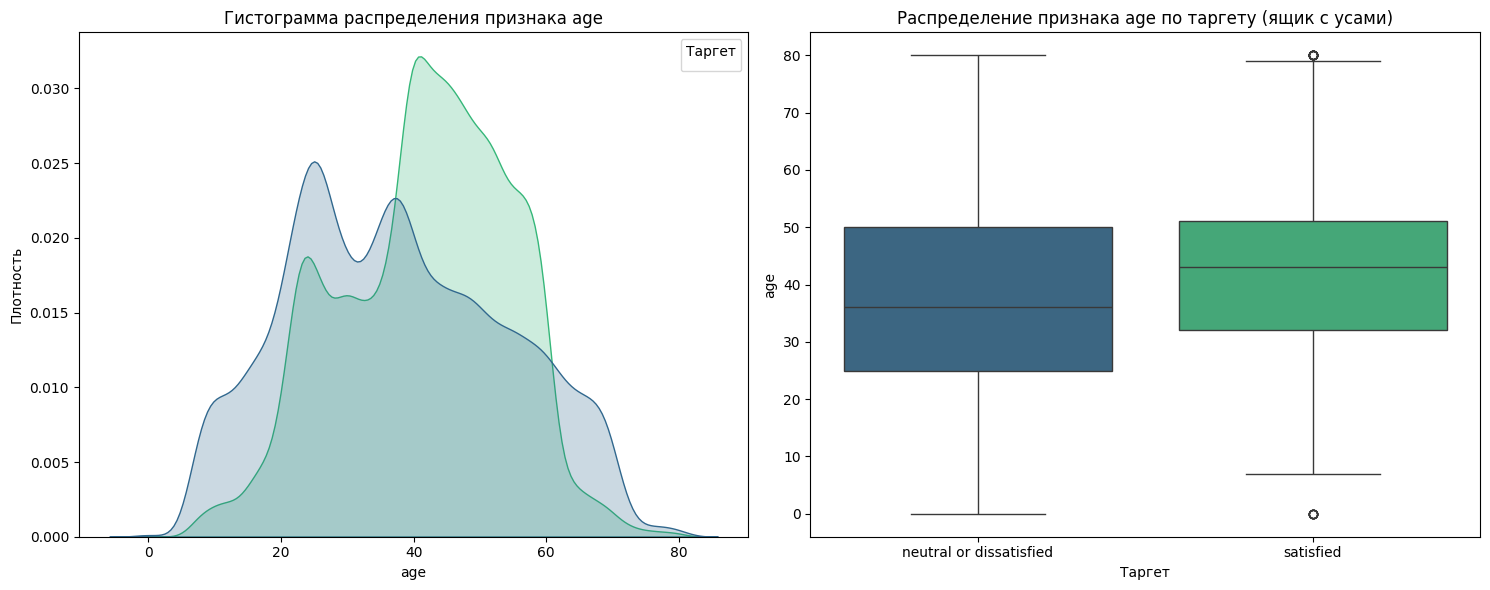

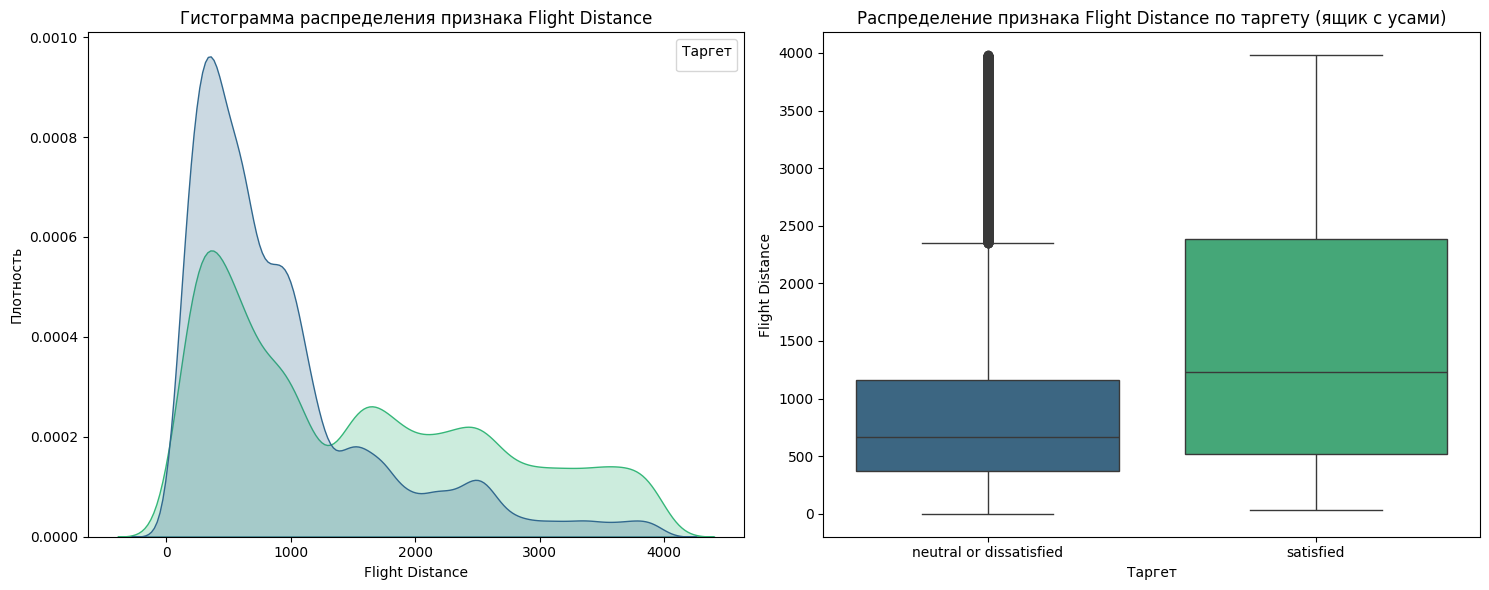

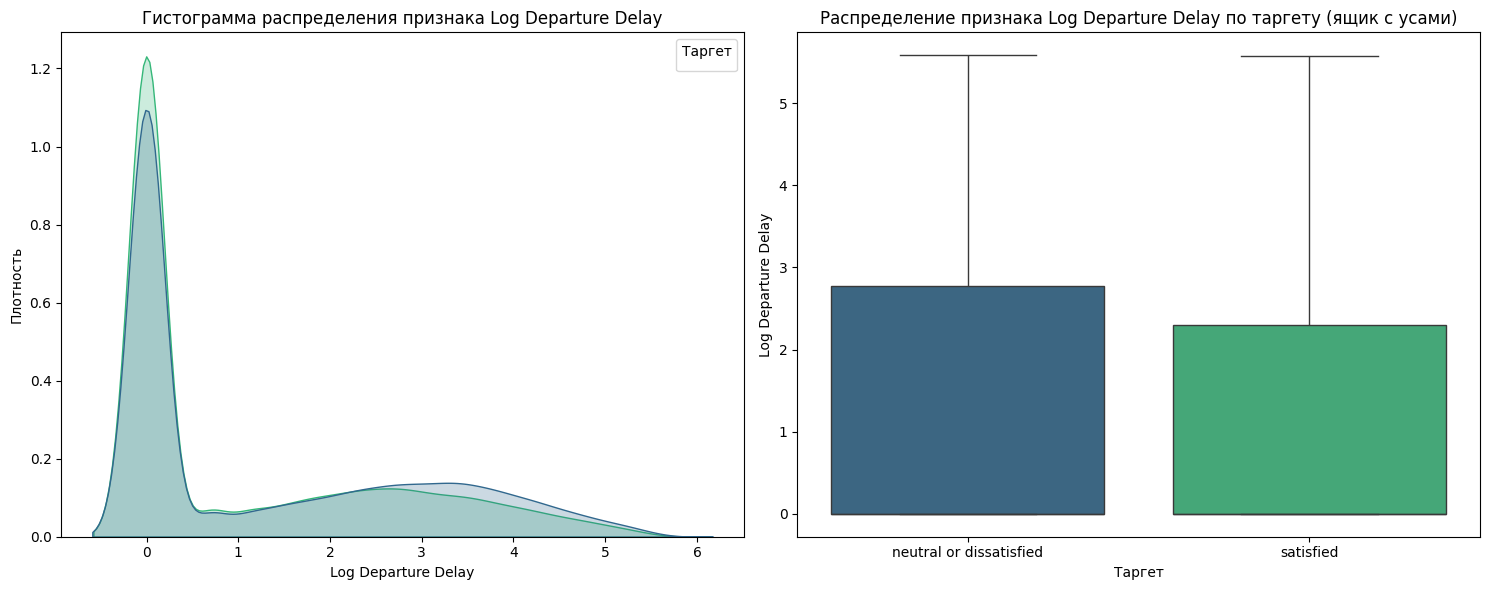

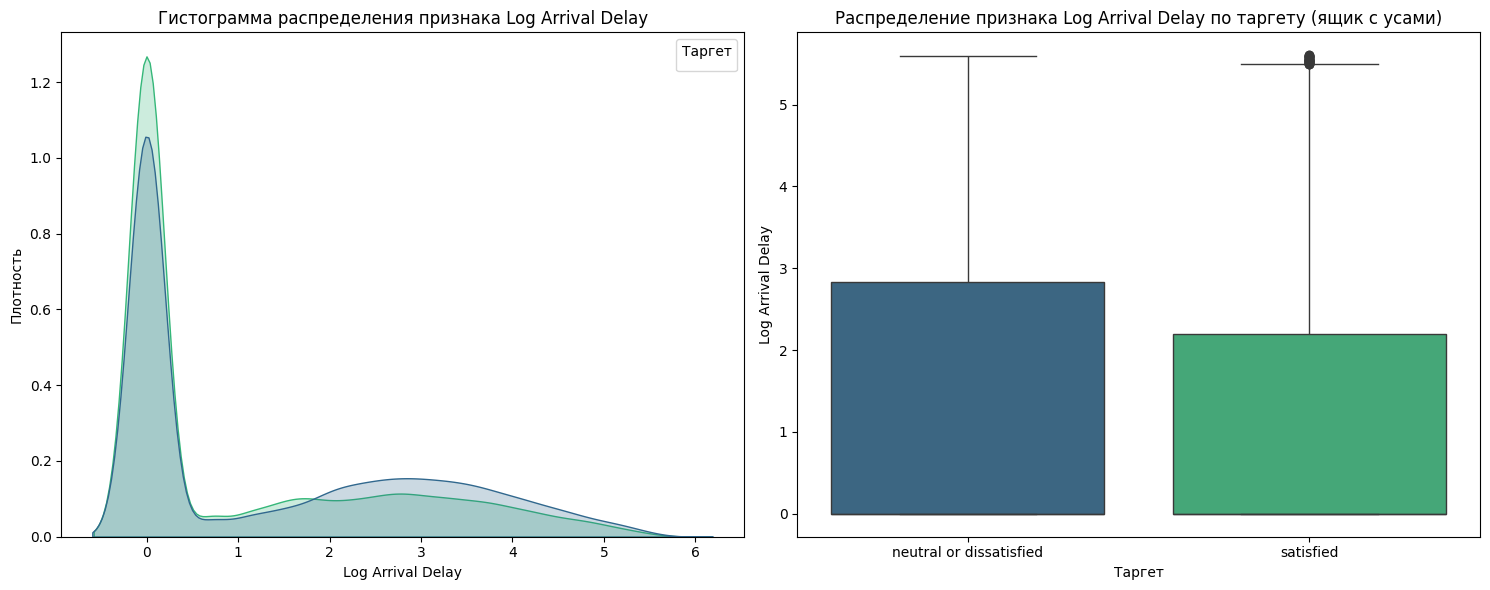

In [ ]:
X_train["Log Departure Delay"] = np.log1p(X_train["Departure Delay in Minutes"])
X_train["Log Arrival Delay"] = np.log1p(X_train["Arrival Delay in Minutes"])
X_val["Log Departure Delay"] = np.log1p(X_val["Departure Delay in Minutes"])
X_val["Log Arrival Delay"] = np.log1p(X_val["Arrival Delay in Minutes"])

# Обновляем список континуальных признаков
continuous_cols = ["age", "Flight Distance", "Log Departure Delay", "Log Arrival Delay"]

# Графики после логарифмирования
plot_continuous(continuous_cols, X_train, y_train)

Построение.

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

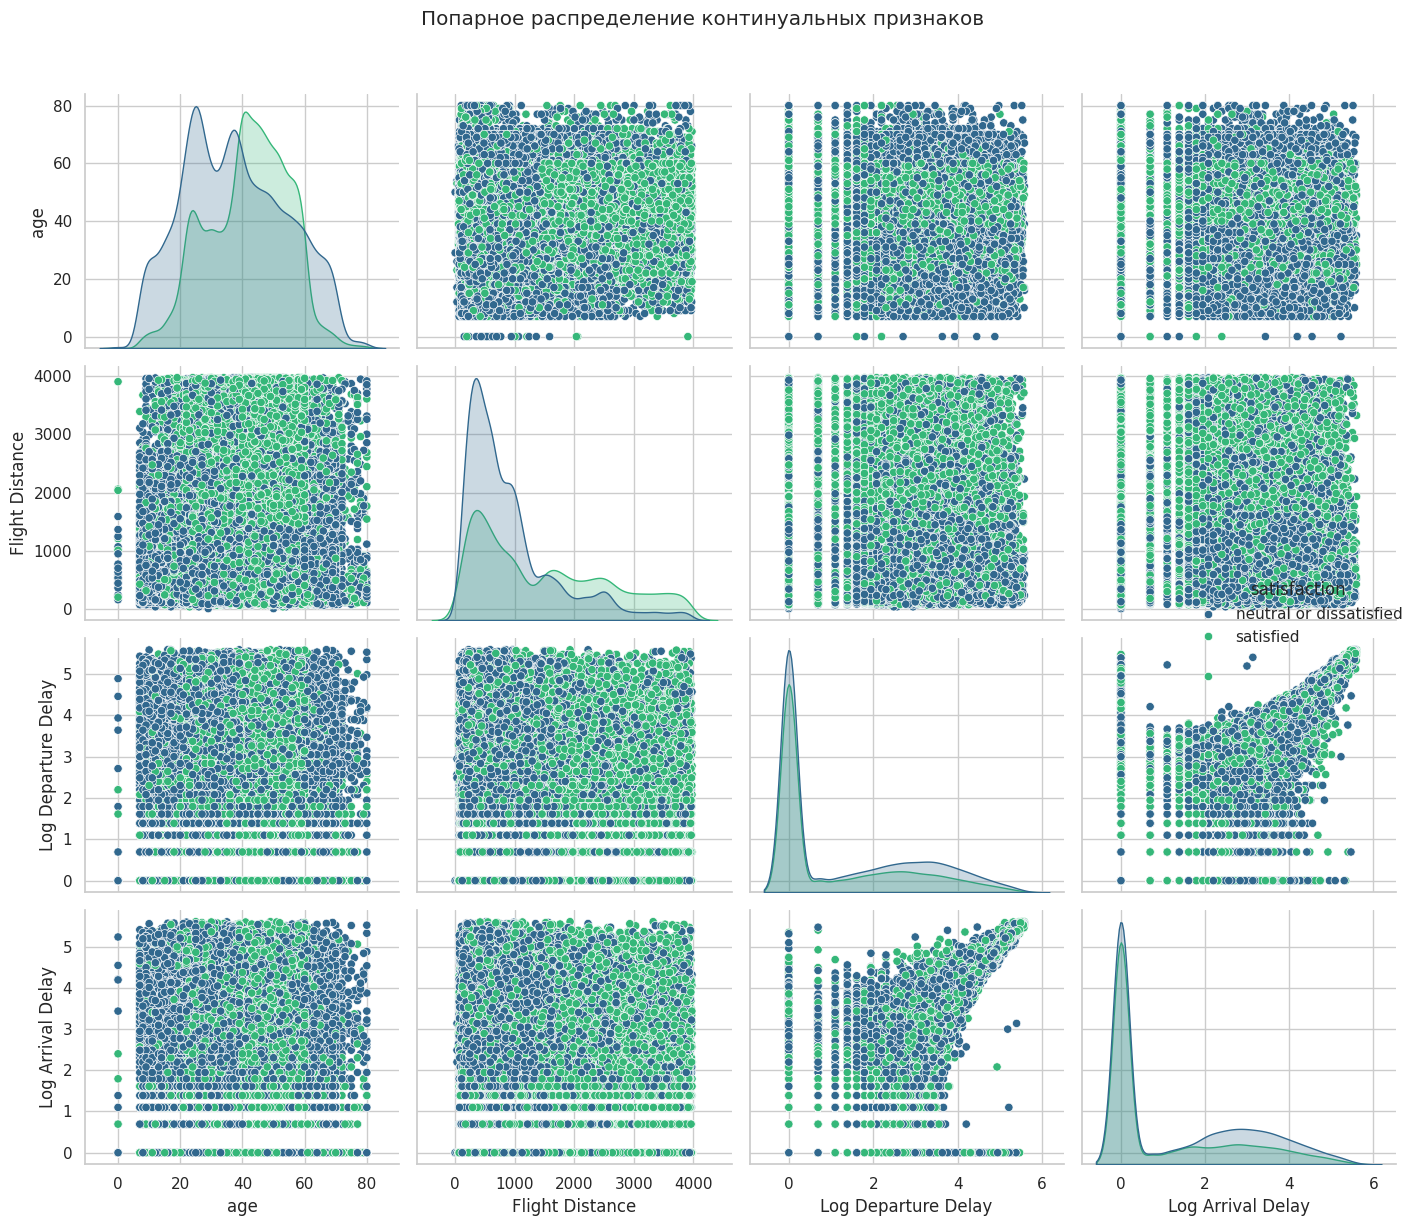

In [ ]:
# Добавляем y_train как новую колонку к X_train временно для построения графика
X_train_with_target = X_train.copy()
X_train_with_target['satisfaction'] = y_train

sns.set(style="whitegrid")
pairplot = sns.pairplot(
    data=X_train_with_target[continuous_cols + ['satisfaction']],
    hue="satisfaction",
    palette="viridis",
    diag_kind="kde",
    height=3
)

pairplot.fig.suptitle("Попарное распределение континуальных признаков", y=1.02)
pairplot.fig.tight_layout()
pairplot.fig.subplots_adjust(top=0.95)
plt.show()

# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [ ]:
# Кодирование таргета: 'satisfied' -> 1, остальные -> 0
y_train = y_train.apply(lambda x: 1 if x == 'satisfied' else 0)
y_val = y_val.apply(lambda x: 1 if x == 'satisfied' else 0)

print("Закодированный таргет:")
y_train.value_counts()

Закодированный таргет:


satisfaction
0    40484
1    30911
Name: count, dtype: int64

In [ ]:
# Выбор категориальных признаков
categorical_cols = list(X_train.select_dtypes(include='object').columns)

# Применение OHE для категориальных признаков
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_val_encoded = pd.get_dummies(X_val, columns=categorical_cols, drop_first=True)

# Приведение к одинаковой структуре данных
X_val_encoded = X_val_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

print("Размеры после кодирования:")
print(f"X_train: {X_train_encoded.shape}, X_val: {X_val_encoded.shape}")

Размеры после кодирования:
X_train: (71395, 25), X_val: (30588, 25)


### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [ ]:
model = DecisionTreeClassifier(random_state=42)

model.fit(X_train_encoded, y_train)

# Предсказания на валидационной выборке
y_pred = model.predict(X_val_encoded)

val_accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy на валидационной выборке: {val_accuracy:.4f}")

Accuracy на валидационной выборке: 0.9422


## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [ ]:
X_train_np = X_train_encoded.to_numpy()
X_val_np = X_val_encoded.to_numpy()
y_train_np = y_train.to_numpy()
y_val_np = y_val.to_numpy()

In [ ]:
error_dt, bias_dt, var_dt = bias_variance_decomp(
    model,
    X_train_np,
    y_train_np,
    X_val_np,
    y_val_np,
    loss='0-1_loss',
    random_seed=42
)

print(f"Error: {error_dt:.4f}")
print(f"Bias: {bias_dt:.4f}")
print(f"Variance: {var_dt:.4f}")

Error: 0.0619
Bias: 0.0411
Variance: 0.0461


### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [ ]:
tree_depth = model.get_depth()
tree_leaves = model.get_n_leaves()

print(f"Глубина дерева: {tree_depth}")
print(f"Количество листьев: {tree_leaves}")

Глубина дерева: 31
Количество листьев: 2094


* Глубина дерева:

Глубина является довольно большой, что может быть признаком переобучения. Такое дерево может хорошо справляться с обучающими данными, но обобщать на новых данных оно будет хуже

* Количество листьев:

Большое количество листьев указывает на то, что дерево сильно разветвлено.
Это также свидетельствует о возможном переобучении, так как каждая ветвь может быть слишком специфичной для обучающих данных


### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

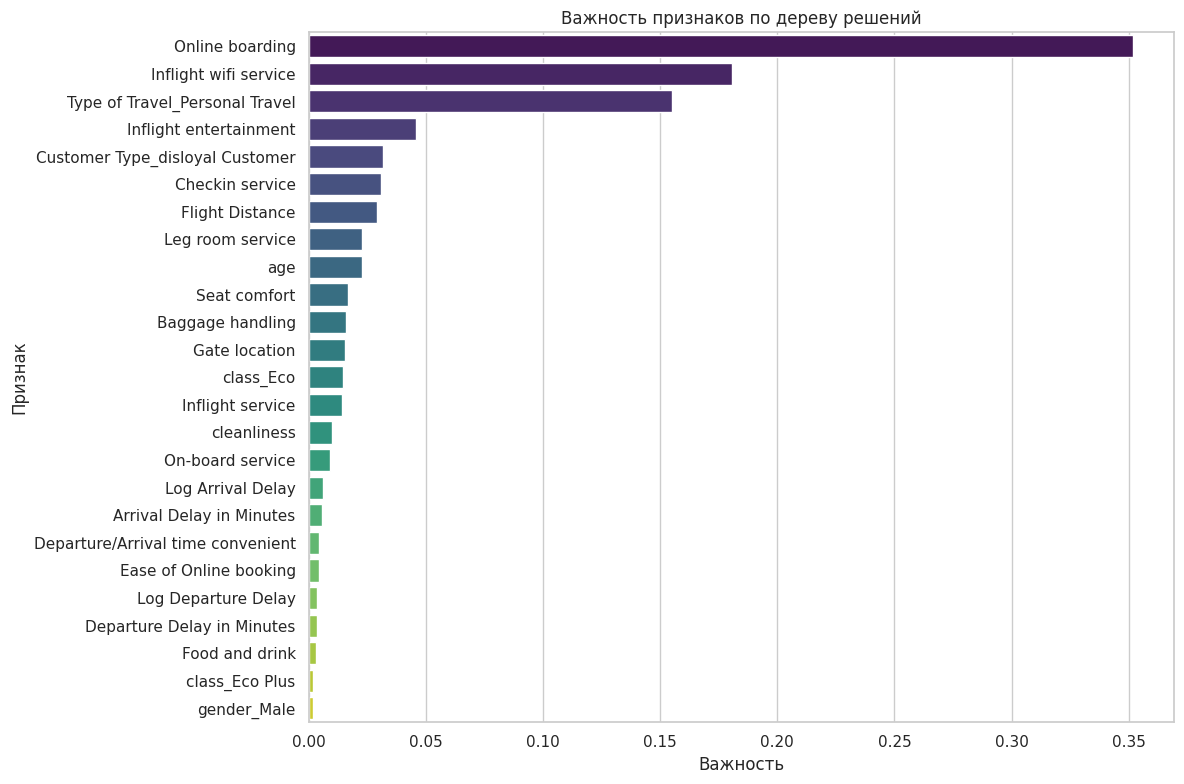

Топ-5 наиболее информативных признаков:
                            Feature  Importance
9                   Online boarding    0.351776
4             Inflight wifi service    0.180467
22   Type of Travel_Personal Travel    0.155062
11           Inflight entertainment    0.045534
21  Customer Type_disloyal Customer    0.031660


In [ ]:
feature_importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette="viridis")
plt.title("Важность признаков по дереву решений")
plt.xlabel("Важность")
plt.ylabel("Признак")
plt.tight_layout()
plt.show()

print("Топ-5 наиболее информативных признаков:")
print(feature_importance_df.head(5))

### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [ ]:
top_2_features = ['Online boarding', 'Inflight wifi service']

X_train_top2 = X_train_encoded[top_2_features]
X_val_top2 = X_val_encoded[top_2_features]

model_top2 = DecisionTreeClassifier(max_depth=5, random_state=42)

model_top2.fit(X_train_top2, y_train)

y_pred_top2 = model_top2.predict(X_val_top2)

accuracy_top2 = accuracy_score(y_val, y_pred_top2)

print(f"Accuracy на валидационной выборке с 2 признаками: {accuracy_top2:.4f}")

Accuracy на валидационной выборке с 2 признаками: 0.8248


### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

In [ ]:
import graphviz

In [ ]:
dot_data = export_graphviz(
    model_top2,
    out_file=None,
    feature_names=top_2_features,
    class_names=['neutral or dissatisfied', 'satisfied'],
    filled=True,
    rounded=True,
    special_characters=True
)

graph = graphviz.Source(dot_data)
graph.render("decision_tree_top2", format="png", cleanup=True)
graph.view()

'decision_tree_top2.pdf'

Почему предикаты кратны 1/2

При построении дерева решений с использованием алгоритма CART (Classification and Regression Tree), алгоритм ищет пороги разделения для каждого признака, чтобы минимизировать критерий (например, Gini impurity или энтропию).
В процессе вычисления оптимальных порогов значения могут быть усреднены между соседними наблюдениями. Если значения признаков целые, пороги могут быть средними значениями между двумя соседними, отсюда и дробные значения (например, 1/2)

Это не связано с округлением данных, а с математикой, лежащей в основе алгоритма

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

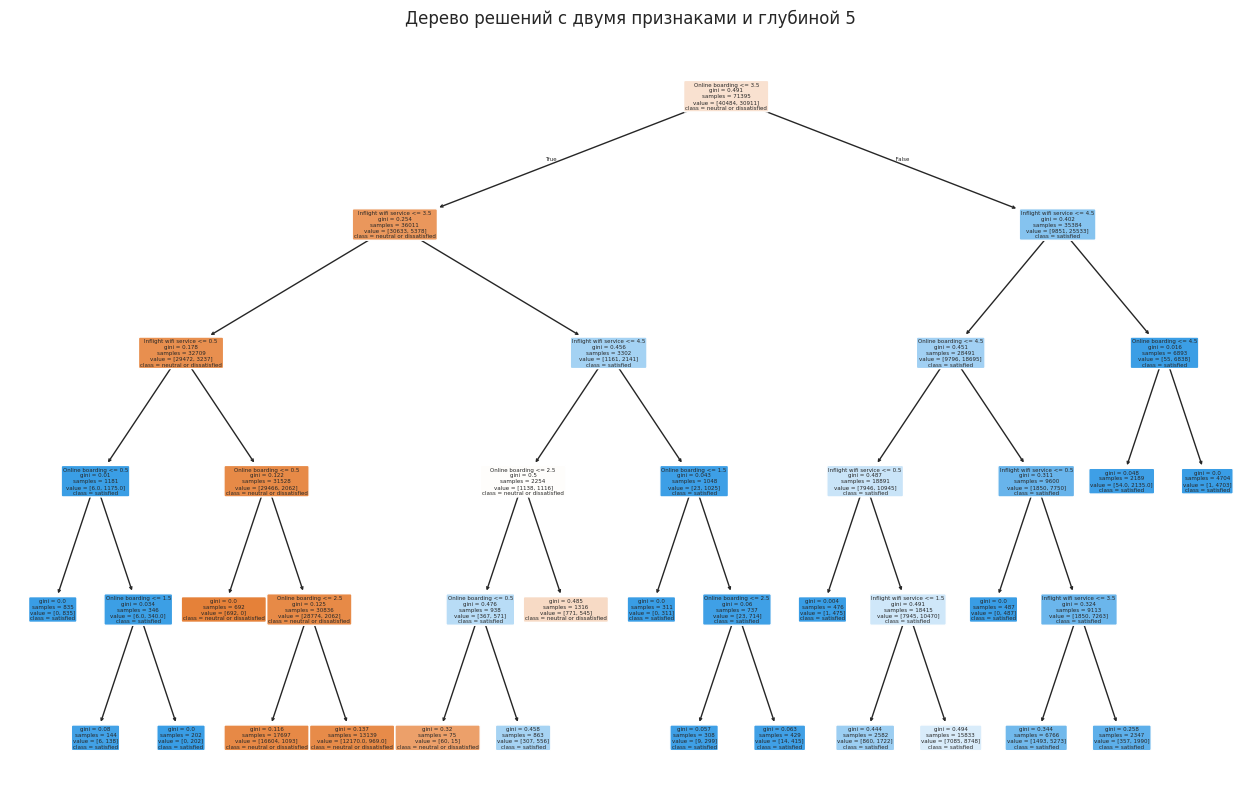

In [ ]:
plt.figure(figsize=(16, 10))
plot_tree(
    model_top2,
    feature_names=top_2_features,
    class_names=['neutral or dissatisfied', 'satisfied'],
    filled=True,
    rounded=True
)
plt.title("Дерево решений с двумя признаками и глубиной 5")
plt.show()

Дерево решений получилось асимметричным.

Левая и правая ветви развиваются по-разному: одна ветвь может быть глубже, чем другая, а количество узлов в каждой ветви заметно отличается

Это связано с различной информативностью двух признаков - например, Online boarding может давать больше информации для разделения классов, поэтому дерево глубже исследует этот признак


1. Плюсы асимметрии:
Она показывает, что модель адаптировалась к данным и использует признаки в соответствии с их важностью.

Более "глубокая" ветвь может указывать на более сложные зависимости, которые модель выявляет в данных

2. Минусы асимметрии:

Если дерево сильно асимметрично, это может указывать на перекос данных (например, сильный дисбаланс классов) или шум в данных

### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

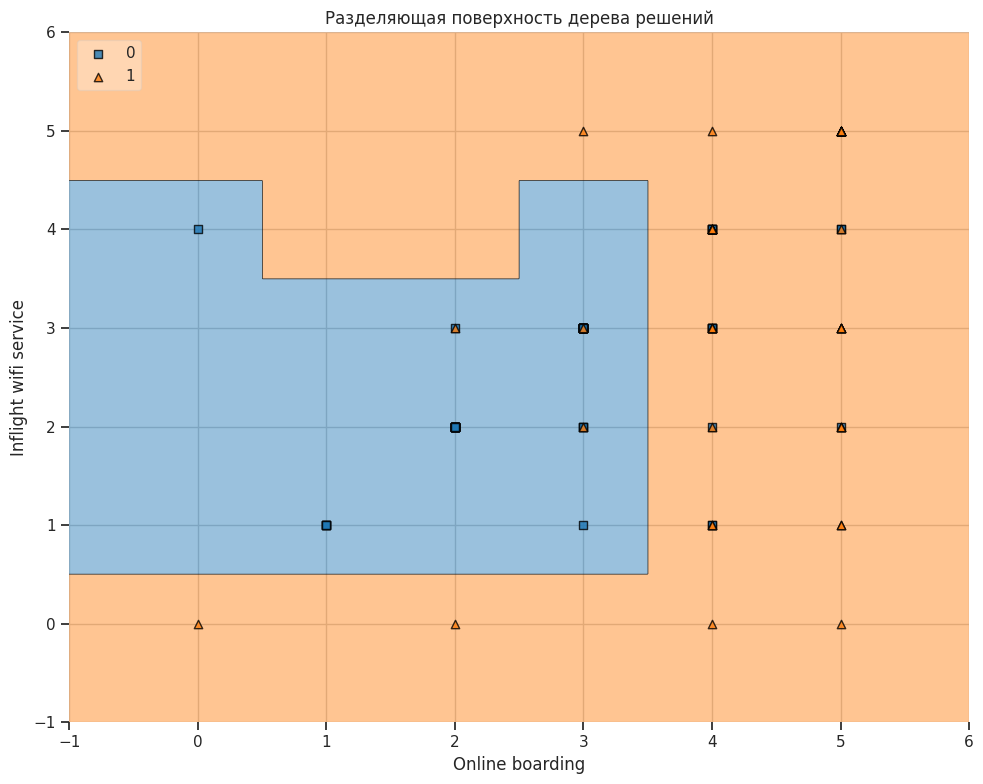

In [ ]:
# Используем только первые 100 объектов обучающей выборки
X_train_sample = X_train_top2.iloc[:100, :].to_numpy()
y_train_sample = y_train.iloc[:100].to_numpy()

# Отображение разделяющей поверхности
plt.figure(figsize=(10, 8))
plot_decision_regions(X_train_sample, y_train_sample, clf=model_top2, legend=2)

# Добавление заголовка и меток
plt.title("Разделяющая поверхность дерева решений")
plt.xlabel("Online boarding")
plt.ylabel("Inflight wifi service")
plt.tight_layout()
plt.show()

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

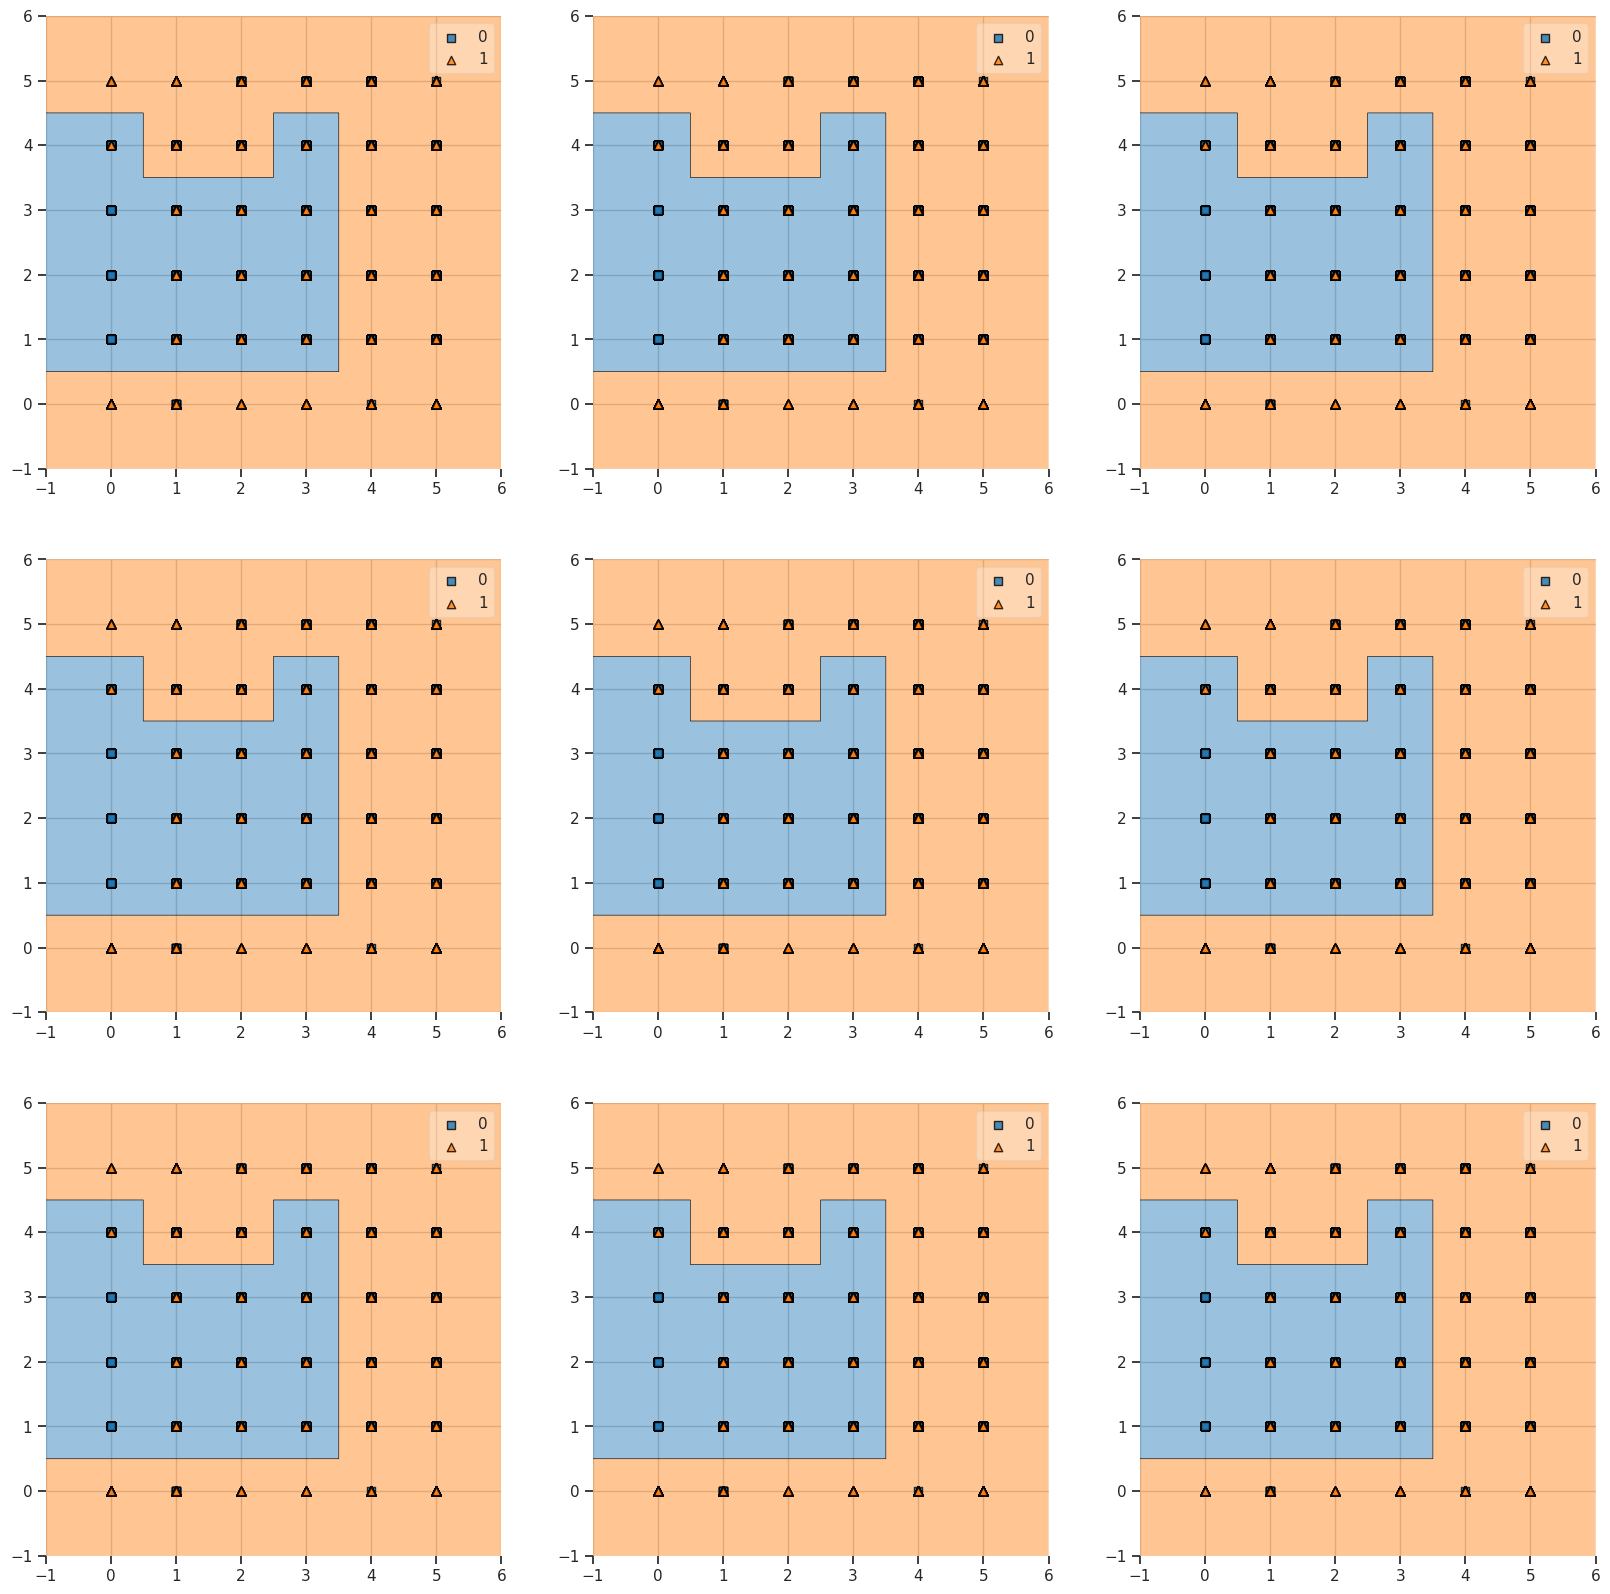

In [ ]:
X_train_example = X_train_top2.copy()

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_example.index, size=X_train_example.shape[0] - 100, replace=False)

        # Использование случайного состояния генератора
        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=np.random.randint(100))
        tree_exp.fit(X_train_example.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_example.loc[inds, :]),
                              y=np.array(y_train[inds]), ax=ax[row][col])

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [ ]:
# замените X_train_example на вашу переменную (ohe-encoded)
X_train_example = X_train_top2.copy()
X_val_example = X_val_top2.copy()

In [ ]:
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in tqdm(depths):
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_example, y_train)
    y_predicted_train = DT.predict(X_train_example)
    y_predicted_val = DT.predict(X_val_example)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

100%|██████████| 12/12 [00:00<00:00, 16.12it/s]


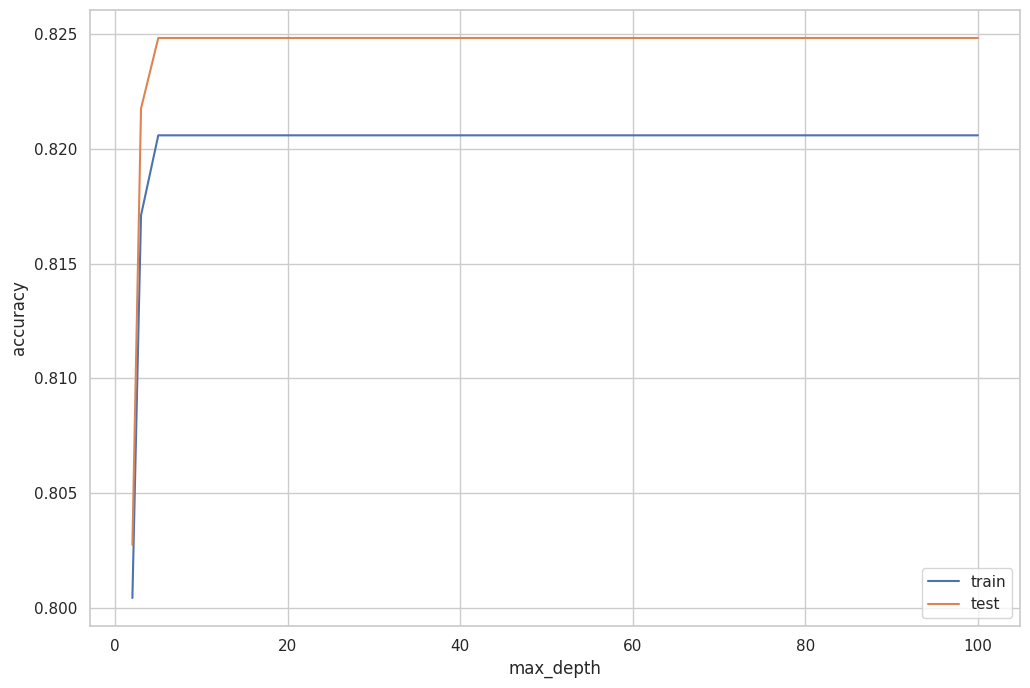

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [ ]:
param_grid = {
    'max_depth': [3, 5, 10, 15, 20],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

tree = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    cv=5,  # 5-фолдовая кросс-валидация
    scoring='accuracy',  # Оптимизируем метрику accuracy
    n_jobs=-1,  # Используем все процессоры
    verbose=1  # Отображение процесса
)

grid_search.fit(X_train_encoded, y_train)

best_params = grid_search.best_params_
print(f"Лучшие параметры: {best_params}")

best_model = grid_search.best_estimator_
best_model.fit(X_train_encoded, y_train)

y_pred_best = best_model.predict(X_val_encoded)
val_accuracy_best = accuracy_score(y_val, y_pred_best)
print(f"Accuracy на валидационной выборке после подбора гиперпараметров: {val_accuracy_best:.4f}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Лучшие параметры: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 20}
Accuracy на валидационной выборке после подбора гиперпараметров: 0.9507


### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [ ]:
with open('DT.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Модель успешно сохранена в файл 'best_decision_tree.pkl'")

Модель успешно сохранена в файл 'best_decision_tree.pkl'


# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [ ]:
# Инициализация случайного леса с параметрами по умолчанию
rf_model = RandomForestClassifier(random_state=42)

# Обучение модели на тренировочных данных
rf_model.fit(X_train_encoded, y_train)

# Предсказания на валидационной выборке
y_pred_rf = rf_model.predict(X_val_encoded)

# Оценка качества модели
val_accuracy_rf = accuracy_score(y_val, y_pred_rf)
print(f"Accuracy случайного леса с параметрами по умолчанию на валидационной выборке: {val_accuracy_rf:.4f}")

Accuracy случайного леса с параметрами по умолчанию на валидационной выборке: 0.9604


### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

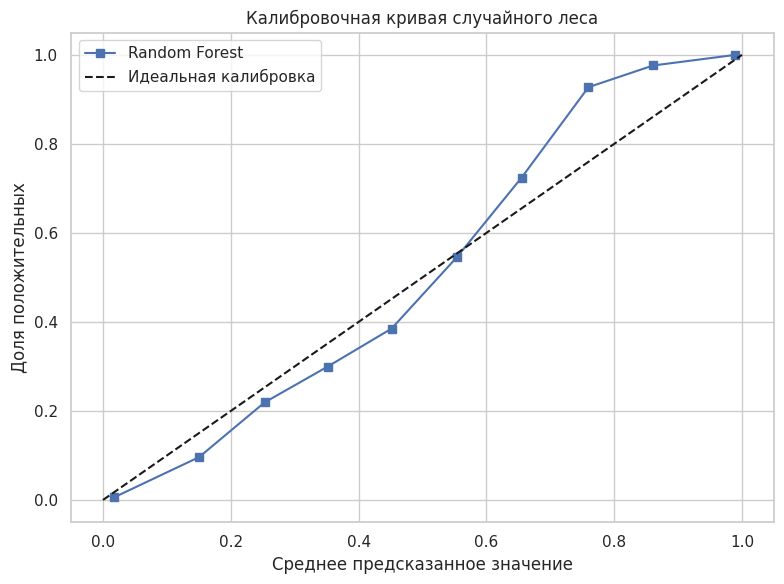

In [ ]:
y_prob_rf = rf_model.predict_proba(X_val_encoded)[:, 1]

# Вычисление калибровочной кривой
fraction_of_positives, mean_predicted_value = calibration_curve(y_val, y_prob_rf, n_bins=10, strategy='uniform')

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Random Forest")
plt.plot([0, 1], [0, 1], "k--", label="Идеальная калибровка")
plt.title("Калибровочная кривая случайного леса")
plt.xlabel("Среднее предсказанное значение")
plt.ylabel("Доля положительных")
plt.legend()
plt.tight_layout()
plt.show()

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?



```
Ваш ответ здесь
```



In [ ]:
# Предсказанные вероятности случайного леса
y_prob_rf = rf_model.predict_proba(X_val_encoded)[:, 1]

# Вычисление Brier Score
brier_score = brier_score_loss(y_val, y_prob_rf)
print(f"Brier Score случайного леса: {brier_score:.4f}")

Brier Score случайного леса: 0.0303


### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

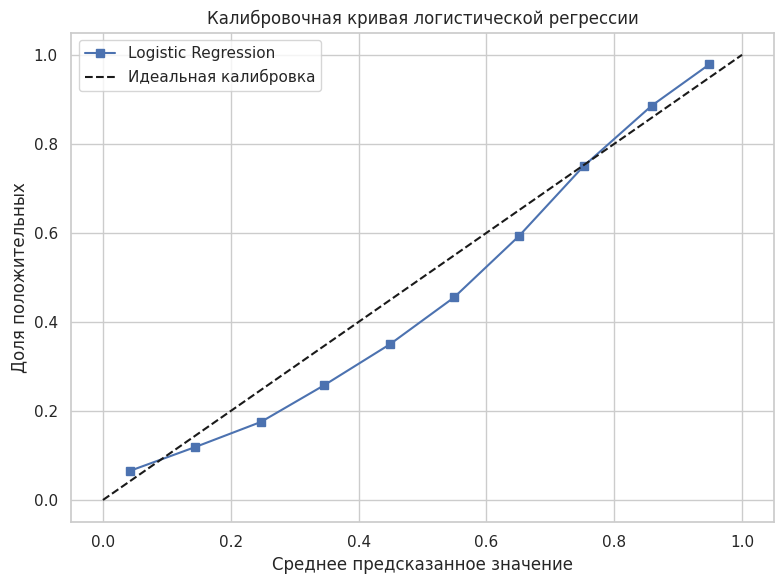

In [ ]:
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
log_reg.fit(X_train_encoded, y_train)

y_prob_log_reg = log_reg.predict_proba(X_val_encoded)[:, 1]

# Калибровочная кривая
fraction_of_positives, mean_predicted_value = calibration_curve(y_val, y_prob_log_reg, n_bins=10, strategy='uniform')

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Logistic Regression")
plt.plot([0, 1], [0, 1], "k--", label="Идеальная калибровка")
plt.title("Калибровочная кривая логистической регрессии")
plt.xlabel("Среднее предсказанное значение")
plt.ylabel("Доля положительных")
plt.legend()
plt.tight_layout()
plt.show()

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?



```
Ваш ответ здесь
```


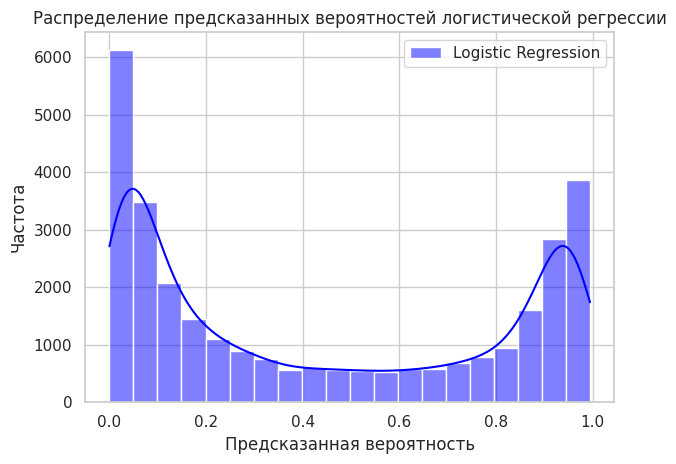

In [ ]:
sns.histplot(y_prob_log_reg, kde=True, bins=20, color="blue", label="Logistic Regression")
plt.title("Распределение предсказанных вероятностей логистической регрессии")
plt.xlabel("Предсказанная вероятность")
plt.ylabel("Частота")
plt.legend()
plt.tight_layout()
plt.show()

Большинство предсказанных вероятностей находятся близко к 0 и 1.
Это означает, что модель часто делает уверенные предсказания, классифицируя объекты как однозначно принадлежащие к классу 0 (неудовлетворённые) или классу 1 (удовлетворённые)

### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

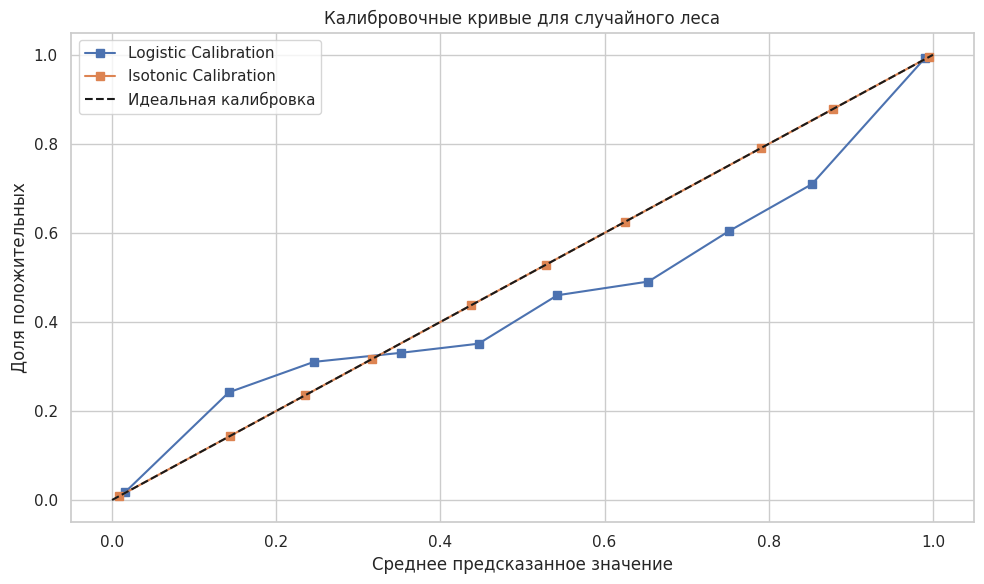

In [ ]:
# Логистическая регрессия для калибровки
rf_logistic_calibrated = CalibratedClassifierCV(estimator=rf_model, method='sigmoid', cv='prefit')
rf_logistic_calibrated.fit(X_val_encoded, y_val)

# Изотоническая регрессия для калибровки
rf_isotonic_calibrated = CalibratedClassifierCV(estimator=rf_model, method='isotonic', cv='prefit')
rf_isotonic_calibrated.fit(X_val_encoded, y_val)

# Предсказание вероятностей после калибровки
y_prob_rf_logistic = rf_logistic_calibrated.predict_proba(X_val_encoded)[:, 1]
y_prob_rf_isotonic = rf_isotonic_calibrated.predict_proba(X_val_encoded)[:, 1]

# Калибровочные кривые
fraction_of_positives_log, mean_predicted_value_log = calibration_curve(y_val, y_prob_rf_logistic, n_bins=10)
fraction_of_positives_iso, mean_predicted_value_iso = calibration_curve(y_val, y_prob_rf_isotonic, n_bins=10)

# Построение графиков
plt.figure(figsize=(10, 6))
plt.plot(mean_predicted_value_log, fraction_of_positives_log, "s-", label="Logistic Calibration")
plt.plot(mean_predicted_value_iso, fraction_of_positives_iso, "s-", label="Isotonic Calibration")
plt.plot([0, 1], [0, 1], "k--", label="Идеальная калибровка")
plt.title("Калибровочные кривые для случайного леса")
plt.xlabel("Среднее предсказанное значение")
plt.ylabel("Доля положительных")
plt.legend()
plt.tight_layout()
plt.show()

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)



```
Ваш ответ здесь
```


### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [ ]:
# Преобразование данных для работы с bias_variance_decomp
X_train_array = X_train_encoded.to_numpy()
y_train_array = y_train.to_numpy()
X_val_array = X_val_encoded.to_numpy()
y_val_array = y_val.to_numpy()

# Расчет смещения и разброса для случайного леса
error_rf, bias_rf, var_rf = bias_variance_decomp(
    RandomForestClassifier(random_state=42),  # Случайный лес
    X_train_array,
    y_train_array,
    X_val_array,
    y_val_array,
    loss='0-1_loss',  # Используем 0-1 loss
    random_seed=42
)

print(f"Error случайного леса: {error_rf:.4f}")
print(f"Bias случайного леса: {bias_rf:.4f}")
print(f"Variance случайного леса: {var_rf:.4f}")

Error случайного леса: 0.0407
Bias случайного леса: 0.0390
Variance случайного леса: 0.0095



```
Ваш ответ здесь
```

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [ ]:
X_train_array = X_train_encoded.to_numpy()
y_train_array = y_train.to_numpy()
X_val_array = X_val_encoded.to_numpy()
y_val_array = y_val.to_numpy()

# Расчет смещения и разброса для логистической регрессии
error_lr, bias_lr, var_lr = bias_variance_decomp(
    LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42),
    X_train_array,
    y_train_array,
    X_val_array,
    y_val_array,
    loss='0-1_loss',  # Используем 0-1 loss
    random_seed=42
)

In [ ]:
print(f"Error логистической регрессии: {error_lr:.4f}")
print(f"Bias логистической регрессии: {bias_lr:.4f}")
print(f"Variance логистической регрессии: {var_lr:.4f}")

Error логистической регрессии: 0.1313
Bias логистической регрессии: 0.1305
Variance логистической регрессии: 0.0099


### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np
rf = RandomForestClassifier(random_state=42)

param_distributions = {
    'n_estimators': randint(50, 200),           # Количество деревьев от 50 до 200
    'max_depth': randint(5, 20),               # Максимальная глубина от 5 до 20
    'min_samples_split': uniform(0.01, 0.1),   # Минимальное количество образцов для разбиения
    'min_samples_leaf': randint(1, 10),        # Минимальное количество листьев от 1 до 10
    'max_features': ['sqrt', 'log2', None],    # Максимальное количество признаков
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,                  # Количество итераций поиска
    scoring='accuracy',         # Метрика оценки
    cv=3,                       # Кросс-валидация
    random_state=42,
    n_jobs=-1                   # Параллельные вычисления
)

random_search.fit(X_train_encoded, y_train)

best_rf = random_search.best_estimator_
best_params = random_search.best_params_

print(f"Лучшие параметры: {best_params}")
print(f"Accuracy на валидационной выборке: {random_search.best_score_:.4f}")

Лучшие параметры: {'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 0.013142918568673426, 'n_estimators': 101}
Accuracy на валидационной выборке: 0.9342


## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [ ]:
# замените X_train_enc на ваш трейн

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_encoded[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

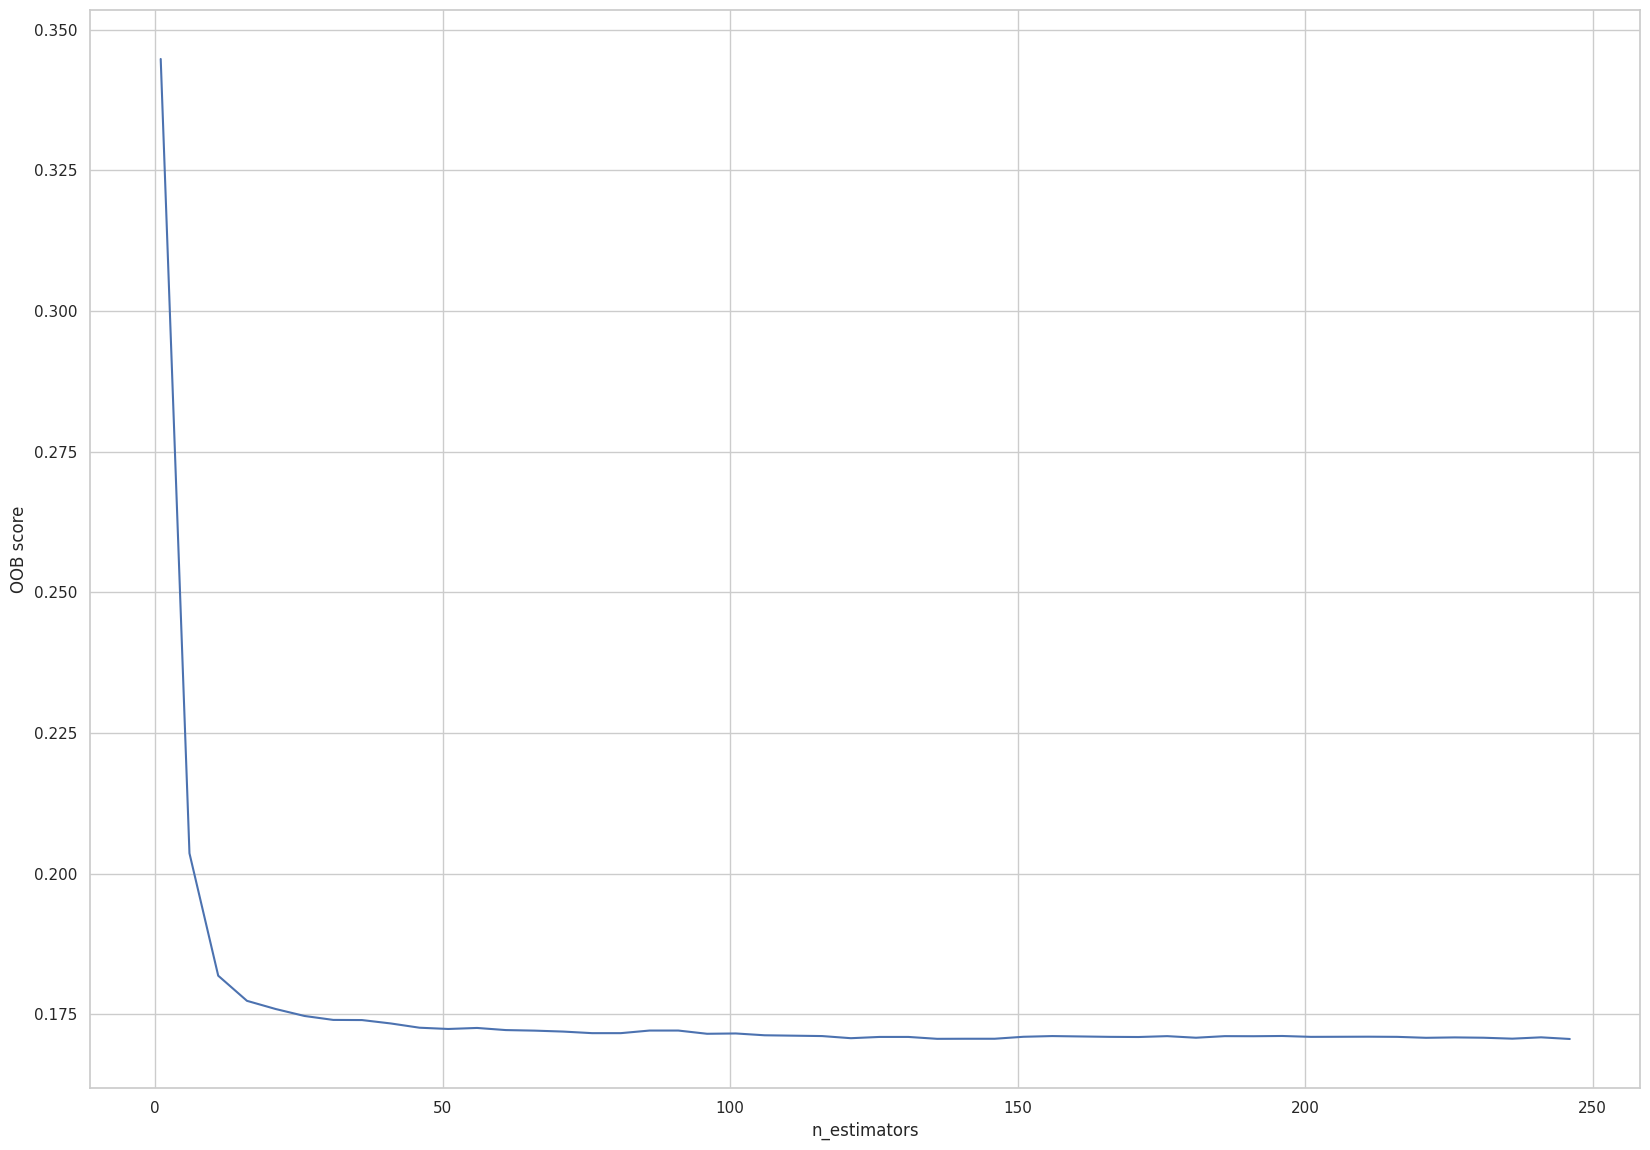

In [ ]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


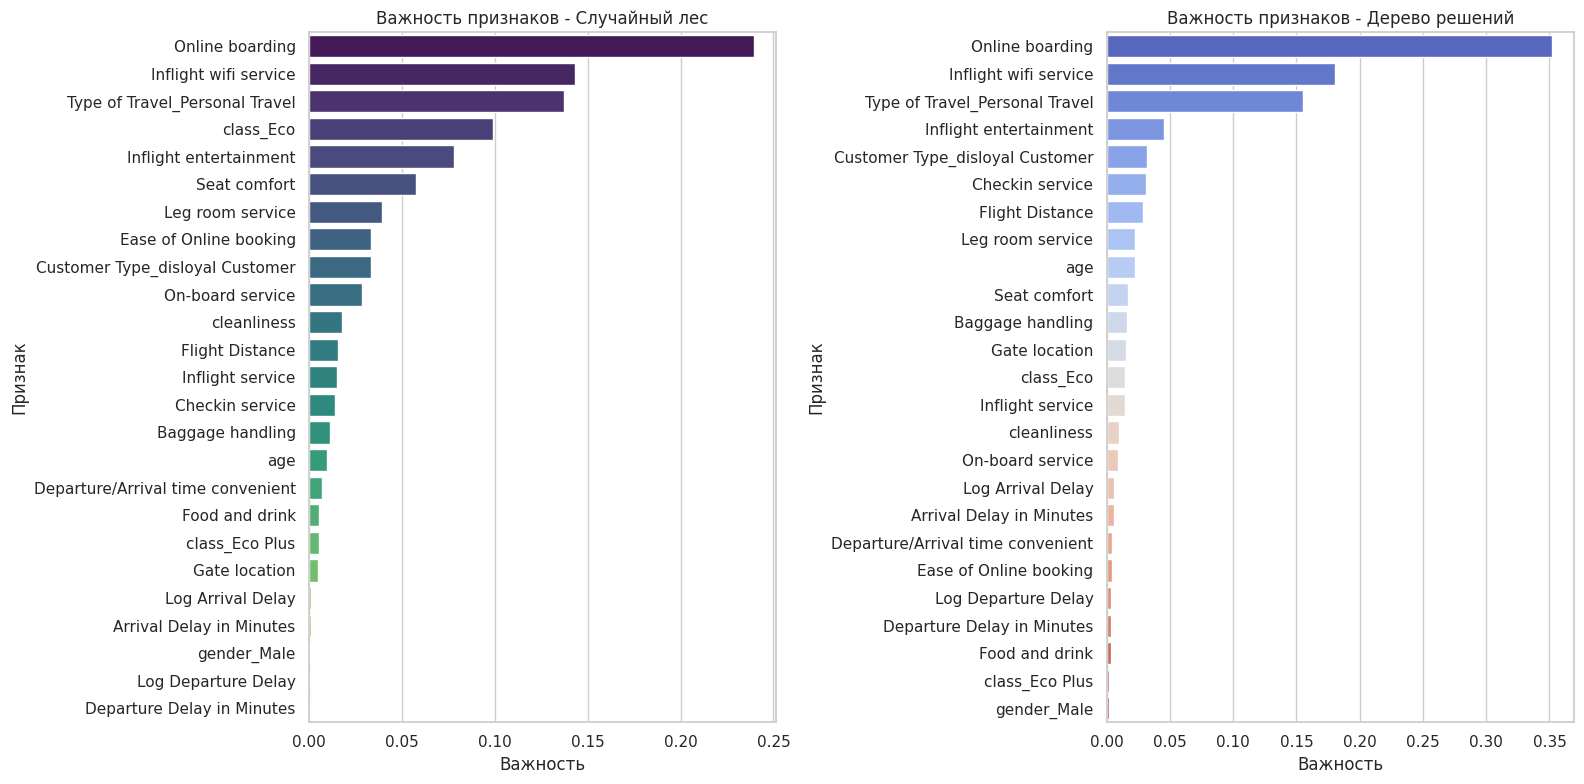

In [ ]:
rf_importances = best_rf.feature_importances_
rf_importance_df = pd.DataFrame({
    'Признак': X_train_encoded.columns,
    'Важность': rf_importances
}).sort_values(by='Важность', ascending=False)

dt_importances = model.feature_importances_
dt_importance_df = pd.DataFrame({
    'Признак': X_train_encoded.columns,
    'Важность': dt_importances
}).sort_values(by='Важность', ascending=False)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.barplot(data=rf_importance_df, x='Важность', y='Признак', palette='viridis')
plt.title('Важность признаков - Случайный лес')
plt.xlabel('Важность')
plt.ylabel('Признак')

plt.subplot(1, 2, 2)
sns.barplot(data=dt_importance_df, x='Важность', y='Признак', palette='coolwarm')
plt.title('Важность признаков - Дерево решений')
plt.xlabel('Важность')
plt.ylabel('Признак')

plt.tight_layout()
plt.show()

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

In [ ]:
with open('best_random_forest.pkl', 'wb') as file:
    pickle.dump(best_rf, file)

print("Лучший случайный лес сохранён в 'best_random_forest.pkl'")

Лучший случайный лес сохранён в 'best_random_forest.pkl'


### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [ ]:
sample_indices = np.random.choice(X_train_encoded.index, size=1000, replace=False)
X_sample = X_train_encoded.loc[sample_indices]

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_sample)

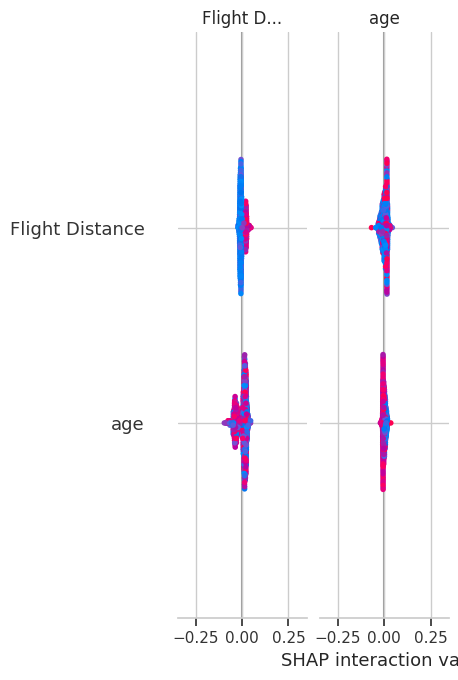

In [ ]:
shap.summary_plot(shap_values, X_sample, plot_type="bar", plot_size=(25, 10))

Взаимодействия между Flight Distance и age слабые, а значит, модель больше полагается на индивидуальное влияние каждого признака

In [ ]:
print(f"SHAP Values Shape: {shap_values[1].shape}")
print(f"X_sample Shape: {X_sample.shape}")

SHAP Values Shape: (25, 2)
X_sample Shape: (1000, 25)


### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

`Ваш ответ здесь`

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [ ]:
# Ваш код здесь


`Ваш ответ здесь`

## Котобонус!

0.25 балла

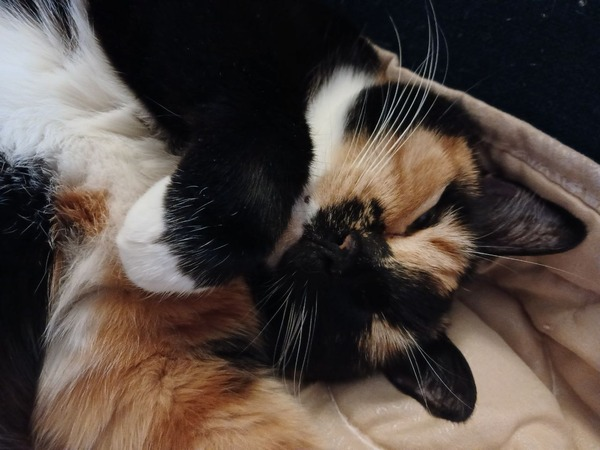

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?